In [2379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FuncFormatter
from scipy.stats import skew, kurtosis, entropy
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import train_test_split,cross_val_score,cross_validate,StratifiedKFold,GridSearchCV 

# Algorithms for supervised learning methods - classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# performance metrics
from sklearn.metrics import classification_report, confusion_matrix,f1_score,recall_score,precision_score,accuracy_score,roc_curve,roc_auc_score,make_scorer

### Data Loading

In [2047]:
movies_path = 'movies.dat'
ratings_path = 'ratings.dat'
users_path = 'users.dat'

movies = pd.read_csv(movies_path, sep='::', header=None, names=['MovieID', 'Title', 'Genres'], encoding='ISO-8859-1')
ratings = pd.read_csv(ratings_path, sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='ISO-8859-1')
users = pd.read_csv(users_path, sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='ISO-8859-1')

print(movies.shape)
print(ratings.shape)
print(users.shape)

C:\Users\hp\AppData\Local\Temp\ipykernel_15048\3715426642.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv(movies_path, sep='::', header=None, names=['MovieID', 'Title', 'Genres'], encoding='ISO-8859-1')
C:\Users\hp\AppData\Local\Temp\ipykernel_15048\3715426642.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv(ratings_path, sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='ISO-8859-1')


(3883, 3)
(1000209, 4)
(6040, 5)


C:\Users\hp\AppData\Local\Temp\ipykernel_15048\3715426642.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv(users_path, sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='ISO-8859-1')


In [2048]:
movies_one ='movies_one.csv'
movies_two ='movies_two.csv'
movies_three ='movies_three.csv'
movies_four = 'movies_four.csv'

omdb_movies = pd.DataFrame()

csv_files = ['movies_one.csv','movies_two.csv','movies_three.csv','movies_four.csv']

for file in csv_files:
    df_temp = pd.read_csv(file,sep=',')
    omdb_movies = pd.concat([omdb_movies, df_temp])
    
omdb_movies = omdb_movies[['MovieID','Title', 'Year', 'Rated','Released','Genre','Director','Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards','Poster', 'imdbRating', 'Type',
       'BoxOffice']]

print(omdb_movies.shape)

(3191, 17)


In [2049]:
# Each user has at least 20 ratings (checking)
aa = ratings.groupby(['UserID'])['MovieID'].count().reset_index()
aa.sort_values(by="MovieID", ascending = True).head()

,UserID,MovieID
946,947,20
4067,4068,20
2529,2530,20
340,341,20
5257,5258,20


### Data Cleaning and Preparation

In [2051]:
omdb_movies['Released'] = pd.to_datetime(omdb_movies['Released'])
print(omdb_movies['Released'].dtype)

omdb_movies['Released_Year'] = omdb_movies['Released'].dt.year
omdb_movies['Released_Year'] = omdb_movies['Released_Year'].fillna(0).astype(int)
omdb_movies['BoxOffice'] = omdb_movies['BoxOffice'].replace({'\$': '', ',': ''}, regex=True).astype(float)

print(omdb_movies['Released_Year'].dtype)
print(omdb_movies['BoxOffice'].dtype)

datetime64[ns]
int32
float64


<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
C:\Users\hp\AppData\Local\Temp\ipykernel_15048\344240994.py:6: SyntaxWarning: invalid escape sequence '\$'
  omdb_movies['BoxOffice'] = omdb_movies['BoxOffice'].replace({'\$': '', ',': ''}, regex=True).astype(float)


In [2052]:
ratings['Timestamp'] = pd.to_datetime(ratings['Timestamp'], unit='s')
ratings['Date'] = pd.to_datetime(ratings['Timestamp'], unit='s').dt.date
ratings['RatingYear'] = pd.to_datetime(ratings['Timestamp'], unit='s').dt.year

In [2053]:
# under 18 teenager
# 18 - 34 yound adult (18,25)
# 35 - 59 middle aged adult(35,45,50)
# 60 - 69 older adult (56+)

def categorize_age(Age):
    if Age == 1:
        return 'Teenager (Under 18)'
    elif 18 <= Age <= 25:
        return 'Young Adult (18-34)'
    elif 35 <= Age <= 50:
        return 'Middle-Aged Adult (35-55)'
    elif Age >= 56:
        return 'Older Adult (56+)'
    else:
        return 'Unknown'  # Optional: Handle unexpected values

# Apply the function to the Age column
users['Age_Group'] = users['Age'].apply(categorize_age)

In [2054]:
movies['Movie_Year'] = movies['Title'].str.extract(r'\((\d{4})\)', expand=False)
movies['Movie_Year'] = movies['Movie_Year'].astype(int)

In [2055]:
movies.head()

,MovieID,Title,Genres,Movie_Year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [2056]:
ratings.head()

,UserID,MovieID,Rating,Timestamp,Date,RatingYear
0,1,1193,5,2000-12-31 22:12:40,2000-12-31,2000
1,1,661,3,2000-12-31 22:35:09,2000-12-31,2000
2,1,914,3,2000-12-31 22:32:48,2000-12-31,2000
3,1,3408,4,2000-12-31 22:04:35,2000-12-31,2000
4,1,2355,5,2001-01-06 23:38:11,2001-01-06,2001


In [2057]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code,Age_Group
0,1,F,1,10,48067,Teenager (Under 18)
1,2,M,56,16,70072,Older Adult (56+)
2,3,M,25,15,55117,Young Adult (18-34)
3,4,M,45,7,02460,Middle-Aged Adult (35-55)
4,5,M,25,20,55455,Young Adult (18-34)


In [2058]:
users.groupby("Age")["UserID"].nunique()

Age
1      222
18    1103
25    2096
35    1193
45     550
50     496
56     380
Name: UserID, dtype: int64

In [2059]:
users["UserID"].nunique()

6040

In [2060]:
# Merging the datasets
# Merge ratings with movies on MovieID
full_data = ratings.merge(movies, on="MovieID").merge(users, on="UserID")
full_data.shape

(1000209, 14)

In [2061]:
full_data_omdb = full_data.merge(omdb_movies, on="MovieID")
full_data_omdb.shape

(920154, 31)

In [2062]:
full_data_df = full_data_omdb.copy()

In [2063]:
pd.set_option("display.max_columns",None)
full_data_df.head(2)

,UserID,MovieID,Rating,Timestamp,Date,RatingYear,Title_x,Genres,Movie_Year,Gender,Age,Occupation,Zip-code,Age_Group,Title_y,Year,Rated,Released,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,imdbRating,Type,BoxOffice,Released_Year
0,1,1193,5,2000-12-31 22:12:40,2000-12-31,2000,One Flew Over the Cuckoo's Nest (1975),Drama,1975,F,1,10,48067,Teenager (Under 18),One Flew Over the Cuckoo's Nest,1975,R,1975-11-19,Drama,Milos Forman,"Lawrence Hauben, Bo Goldman, Ken Kesey","Jack Nicholson, Louise Fletcher, Michael Berryman",McMurphy has a criminal past and has once agai...,English,United States,Won 5 Oscars. 38 wins & 15 nominations total,https://m.media-amazon.com/images/M/MV5BYjBkMj...,8.7,movie,108981275.0,1975
1,1,661,3,2000-12-31 22:35:09,2000-12-31,2000,James and the Giant Peach (1996),Animation|Children's|Musical,1996,F,1,10,48067,Teenager (Under 18),James and the Giant Peach,1996,PG,1996-04-12,"Animation, Adventure, Family",Henry Selick,"Roald Dahl, Karey Kirkpatrick, Jonathan Roberts","Paul Terry, Joanna Lumley, Pete Postlethwaite",James' happy life at the English seaside is ru...,English,"United Kingdom, United States",Nominated for 1 Oscar. 4 wins & 13 nominations...,https://m.media-amazon.com/images/M/MV5BMmQwND...,6.7,movie,28946127.0,1996


### Analysis

In [2066]:
print(full_data_df["MovieID"].nunique())
print(full_data_df["UserID"].nunique())

3087
6040


In [2067]:
# Checking movie by gender rating. If only one gender rate movie, will remove.
chk_rating_gender = full_data_df.groupby(['MovieID','Gender'])['UserID'].count().fillna(0).unstack().reset_index()
not_nan_rows = chk_rating_gender[~(chk_rating_gender['F'].isnull() | chk_rating_gender['M'].isnull())]
print("Movies Rating with both gender : ",not_nan_rows["MovieID"].nunique())
merged_omdb_df = full_data_df.merge(not_nan_rows, on="MovieID")
merged_omdb_df = merged_omdb_df.drop(['F', 'M'], axis=1)
print(merged_omdb_df.shape)
merged_omdb_df.head(2)

Movies Rating with both gender :  2925
(919556, 31)


,UserID,MovieID,Rating,Timestamp,Date,RatingYear,Title_x,Genres,Movie_Year,Gender,Age,Occupation,Zip-code,Age_Group,Title_y,Year,Rated,Released,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,imdbRating,Type,BoxOffice,Released_Year
0,1,1193,5,2000-12-31 22:12:40,2000-12-31,2000,One Flew Over the Cuckoo's Nest (1975),Drama,1975,F,1,10,48067,Teenager (Under 18),One Flew Over the Cuckoo's Nest,1975,R,1975-11-19,Drama,Milos Forman,"Lawrence Hauben, Bo Goldman, Ken Kesey","Jack Nicholson, Louise Fletcher, Michael Berryman",McMurphy has a criminal past and has once agai...,English,United States,Won 5 Oscars. 38 wins & 15 nominations total,https://m.media-amazon.com/images/M/MV5BYjBkMj...,8.7,movie,108981275.0,1975
1,1,661,3,2000-12-31 22:35:09,2000-12-31,2000,James and the Giant Peach (1996),Animation|Children's|Musical,1996,F,1,10,48067,Teenager (Under 18),James and the Giant Peach,1996,PG,1996-04-12,"Animation, Adventure, Family",Henry Selick,"Roald Dahl, Karey Kirkpatrick, Jonathan Roberts","Paul Terry, Joanna Lumley, Pete Postlethwaite",James' happy life at the English seaside is ru...,English,"United Kingdom, United States",Nominated for 1 Oscar. 4 wins & 13 nominations...,https://m.media-amazon.com/images/M/MV5BMmQwND...,6.7,movie,28946127.0,1996


In [2068]:
rating_df = merged_omdb_df.groupby(['MovieID']) \
    .agg(
        total_avg_rating=('Rating', 'mean'),
        tot_rating_count=('Rating', 'count')
    ).fillna(0).reset_index()
rating_df.head(2)

,MovieID,total_avg_rating,tot_rating_count
0,1,4.146846,2077
1,2,3.201141,701


In [2069]:
gender_rating = merged_omdb_df.groupby(['MovieID','Title_x','Genres','Released_Year','Rated','BoxOffice','Gender']) \
    .agg(
        avg_rating=('Rating', 'mean'),
        rating_count=('Rating', 'count')
    ).fillna(0).reset_index()
gender_rating.head(2)

,MovieID,Title_x,Genres,Released_Year,Rated,BoxOffice,Gender,avg_rating,rating_count
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,G,223225679.0,F,4.187817,591
1,1,Toy Story (1995),Animation|Children's|Comedy,1995,G,223225679.0,M,4.130552,1486


In [2070]:
pivot_table_df = gender_rating.pivot_table(
    index=['MovieID','Title_x','Genres','Released_Year','BoxOffice','Rated'],
    columns='Gender',
    values=['avg_rating', 'rating_count'],
    fill_value=0
)
pivot_table_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_table_df.columns]
pivot_table_df = pivot_table_df.reset_index()

In [2071]:
pivot_table_df.head(2)

,MovieID,Title_x,Genres,Released_Year,BoxOffice,Rated,avg_rating_F,avg_rating_M,rating_count_F,rating_count_M
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,223225679.0,G,4.187817,4.130552,591.0,1486.0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,100499940.0,PG,3.278409,3.175238,176.0,525.0


In [2072]:
pivot_table=pivot_table_df.merge(rating_df, on = "MovieID")
pivot_table.head(2)

,MovieID,Title_x,Genres,Released_Year,BoxOffice,Rated,avg_rating_F,avg_rating_M,rating_count_F,rating_count_M,total_avg_rating,tot_rating_count
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,223225679.0,G,4.187817,4.130552,591.0,1486.0,4.146846,2077
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,100499940.0,PG,3.278409,3.175238,176.0,525.0,3.201141,701


In [2073]:
pivot_table['rating_count_F'].sum()

206116.0

In [2074]:
pivot_table['rating_count_M'].sum()

631027.0

In [2078]:
pivot_table['scaled_weighted_avg_F'] = ((
    (pivot_table['avg_rating_F'] * pivot_table['rating_count_F'])
) / pivot_table['rating_count_F'].sum())*100

pivot_table['scaled_weighted_avg_M'] = ((
    (pivot_table['avg_rating_M'] * pivot_table['rating_count_M'])
) / pivot_table['rating_count_M'].sum())*100

pivot_table['scaled_weighted_avg'] = ((
    (pivot_table['total_avg_rating'] * pivot_table['tot_rating_count'])
) / pivot_table['tot_rating_count'].sum())*100

pivot_table['scaled_weighted_diff'] = pivot_table["scaled_weighted_avg_F"] - pivot_table["scaled_weighted_avg_M"]

In [2083]:
pivot_table.query("total_avg_rating>3")["MovieID"].count()

1583

In [2084]:
pv_tbl_over_rated3 = pivot_table.query("total_avg_rating>3")

In [2085]:
pv_tbl_over_rated3[["scaled_weighted_diff"]].describe()

,scaled_weighted_diff
count,1583.000000
mean,0.006277
std,0.110009
min,-0.592816
25%,-0.033887
50%,0.004681
75%,0.046190
max,0.611443


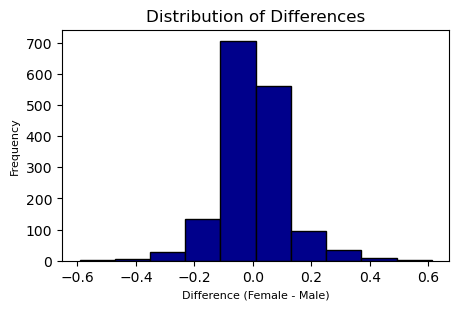

In [2086]:
# Plot histogram
plt.figure(figsize=(5, 3))
plt.hist(pv_tbl_over_rated3["scaled_weighted_diff"], bins=10, edgecolor="black",color="darkblue")
plt.title("Distribution of Differences",fontsize=12)
plt.xlabel("Difference (Female - Male)",fontsize=8)
plt.ylabel("Frequency",fontsize=8)
plt.show()

In [2090]:
# Define percentiles ##same
# lower_percentile = pv_tbl_over_rated3["scaled_weighted_diff"].quantile(0.15)  # 10th percentile -0.0760473928058173
# upper_percentile = pv_tbl_over_rated3["scaled_weighted_diff"].quantile(0.85)  # 90th percentile 0.08647390486178994

lower_thredhold = -0.1
upper_thredhold = 0.1

print("Lower Percentile: ", lower_thredhold)
print("Upper Percentile: ", lower_thredhold)

# Classify movies based on percentiles
pv_tbl_over_rated3["gendered_appeal"] = pv_tbl_over_rated3["scaled_weighted_diff"].apply(
    lambda diff: "Male-Oriented Movie" if diff < lower_thredhold else
                 ("Female-Oriented Movie" if diff > upper_thredhold else
                  "Gender-Neutral Movie")
)

Lower Percentile:  -0.1
Upper Percentile:  -0.1


C:\Users\hp\AppData\Local\Temp\ipykernel_15048\2618285051.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_tbl_over_rated3["gendered_appeal"] = pv_tbl_over_rated3["scaled_weighted_diff"].apply(


In [2092]:
# pv_tbl_over_rated3.to_csv("pv_tbl_over_rated3_movie.csv")

In [2093]:
# Group by gendered appeal and calculate average box office revenue
movie_cnt = pv_tbl_over_rated3.groupby("gendered_appeal")["MovieID"].agg(movie_count='count').reset_index()
print("Total Movies by Gendered Appeal:")
movie_cnt.sort_values(by=['movie_count'], ascending=False)

Total Movies by Gendered Appeal:


,gendered_appeal,movie_count
1,Gender-Neutral Movie,1191
0,Female-Oriented Movie,204
2,Male-Oriented Movie,188


In [2095]:
pv_tbl_over_rated3.head()

,MovieID,Title_x,Genres,Released_Year,BoxOffice,Rated,avg_rating_F,avg_rating_M,rating_count_F,rating_count_M,total_avg_rating,tot_rating_count,scaled_weighted_avg_F,scaled_weighted_avg_M,scaled_weighted_avg,scaled_weighted_diff,gendered_appeal
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,223225679.0,G,4.187817,4.130552,591.0,1486.0,4.146846,2077,1.200780,0.972700,1.028856,0.228080,Female-Oriented Movie
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,100499940.0,PG,3.278409,3.175238,176.0,525.0,3.201141,701,0.279939,0.264173,0.268055,0.015767,Gender-Neutral Movie
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,71518503.0,PG-13,3.073529,2.994152,136.0,342.0,3.016736,478,0.202798,0.162275,0.172253,0.040523,Gender-Neutral Movie
4,5,Father of the Bride Part II (1995),Comedy,1995,76594107.0,PG,3.212963,2.888298,108.0,188.0,3.006757,296,0.168352,0.086050,0.106314,0.082302,Gender-Neutral Movie
5,6,Heat (1995),Action|Crime|Thriller,1995,67436818.0,R,3.682171,3.909988,129.0,811.0,3.878723,940,0.230453,0.502514,0.435529,-0.272061,Male-Oriented Movie


In [2096]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return f'{x * 1e-6:.0f} Mn'

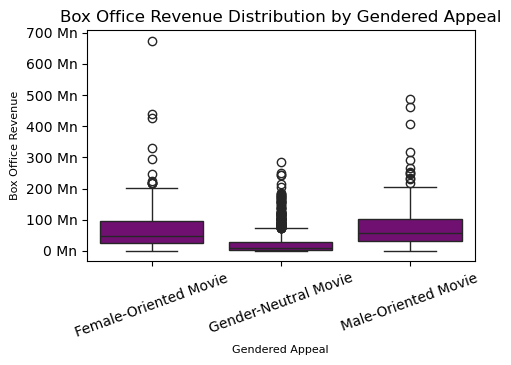

In [2097]:
plt.figure(figsize=(5, 3))
sns.boxplot(x="gendered_appeal", y="BoxOffice", data=pv_tbl_over_rated3,color='purple')
plt.title("Box Office Revenue Distribution by Gendered Appeal",fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.xlabel("Gendered Appeal", fontsize=8)
plt.xticks(rotation=20)
plt.ylabel("Box Office Revenue", fontsize=8)
plt.show()

In [2099]:
def format_revenue(value):
    if value >= 1_000_000_000:
        return f'${value/1_000_000_000:.2f}B'  # Billions
    elif value >= 1_000_000:
        return f'${value/1_000_000:.2f}M'  # Millions
    else:
        return f'${value:.0f}'

In [2100]:
# Group by gendered appeal and calculate average box office revenue
grouped_data = pv_tbl_over_rated3.groupby("gendered_appeal")["BoxOffice"].agg(['mean', 'sum']).reset_index()
grouped_data

,gendered_appeal,mean,sum
0,Female-Oriented Movie,7.110423e+07,1.450526e+10
1,Gender-Neutral Movie,2.321918e+07,2.765404e+10
2,Male-Oriented Movie,8.040260e+07,1.511569e+10


In [2101]:
data=grouped_data.copy()
data["mean"]=data["mean"].apply(format_revenue)
data["sum"]=data["sum"].apply(format_revenue)

# Rename columns for better readability
data.rename(columns={"mean": "Average_Revenue", "sum": "Total_Revenue"}, inplace=True)

print("Average Box Office Revenue by Gendered Appeal:")
avg_rev_gender = data[["gendered_appeal", "Average_Revenue"]]
avg_rev_gender.sort_values(by='Average_Revenue',ascending=False)

Average Box Office Revenue by Gendered Appeal:


,gendered_appeal,Average_Revenue
2,Male-Oriented Movie,$80.40M
0,Female-Oriented Movie,$71.10M
1,Gender-Neutral Movie,$23.22M


In the above table, Male-oriented movies earn slightly more revenue than female-oriented revenue, but gender-neutral movies earn significantly less.

In [2103]:
print("Total Box Office Revenue by Gendered Appeal:")
avg_rev_gender = data[["gendered_appeal", "Total_Revenue"]]
avg_rev_gender.sort_values(by='Total_Revenue',ascending=False)

Total Box Office Revenue by Gendered Appeal:


,gendered_appeal,Total_Revenue
1,Gender-Neutral Movie,$27.65B
2,Male-Oriented Movie,$15.12B
0,Female-Oriented Movie,$14.51B


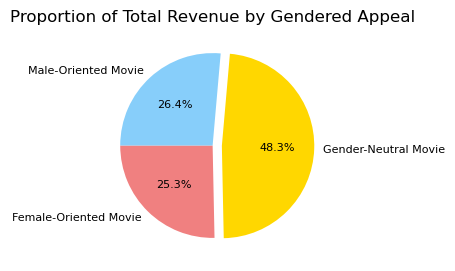

In [2106]:
# Find the largest index based on the 'sum' column
largest_index = grouped_data['sum'].idxmax()

# Create explode list (explode only the largest slice)
explode = [0.1 if i == largest_index else 0 for i in range(len(grouped_data))]
# explode = [0.02] * len(grouped_data)

# Pie Chart: Total Revenue Proportion
plt.figure(figsize=(4, 3))
plt.pie(
    grouped_data["sum"],
    labels=grouped_data["gendered_appeal"],
    autopct='%1.1f%%',
    startangle=180,  # Rotate the chart to start at 90 degrees
    explode=explode,  # Separate the largest portion
    colors=['lightcoral', 'gold', 'lightskyblue'],
    textprops={'fontsize': 8} 
)
plt.title("Proportion of Total Revenue by Gendered Appeal", fontsize=12)
plt.show()

In [2108]:
pv_tbl_over_rated3.head(2)

,MovieID,Title_x,Genres,Released_Year,BoxOffice,Rated,avg_rating_F,avg_rating_M,rating_count_F,rating_count_M,total_avg_rating,tot_rating_count,scaled_weighted_avg_F,scaled_weighted_avg_M,scaled_weighted_avg,scaled_weighted_diff,gendered_appeal
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,223225679.0,G,4.187817,4.130552,591.0,1486.0,4.146846,2077,1.200780,0.972700,1.028856,0.228080,Female-Oriented Movie
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,100499940.0,PG,3.278409,3.175238,176.0,525.0,3.201141,701,0.279939,0.264173,0.268055,0.015767,Gender-Neutral Movie


In [2110]:
genere_separate_tbl = pv_tbl_over_rated3.copy()
genere_separate_tbl['Genres_List'] = genere_separate_tbl['Genres'].str.split('|')
movies_genre_table = genere_separate_tbl.explode('Genres_List')
movies_genre_table.head(5)

,MovieID,Title_x,Genres,Released_Year,BoxOffice,Rated,avg_rating_F,avg_rating_M,rating_count_F,rating_count_M,total_avg_rating,tot_rating_count,scaled_weighted_avg_F,scaled_weighted_avg_M,scaled_weighted_avg,scaled_weighted_diff,gendered_appeal,Genres_List
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,223225679.0,G,4.187817,4.130552,591.0,1486.0,4.146846,2077,1.200780,0.972700,1.028856,0.228080,Female-Oriented Movie,Animation
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,223225679.0,G,4.187817,4.130552,591.0,1486.0,4.146846,2077,1.200780,0.972700,1.028856,0.228080,Female-Oriented Movie,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,223225679.0,G,4.187817,4.130552,591.0,1486.0,4.146846,2077,1.200780,0.972700,1.028856,0.228080,Female-Oriented Movie,Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,100499940.0,PG,3.278409,3.175238,176.0,525.0,3.201141,701,0.279939,0.264173,0.268055,0.015767,Gender-Neutral Movie,Adventure
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,100499940.0,PG,3.278409,3.175238,176.0,525.0,3.201141,701,0.279939,0.264173,0.268055,0.015767,Gender-Neutral Movie,Children's


In [2111]:
# Break down gendered appeal by genre (e.g., action, romance, comedy) and compare the average revenues within each genre.
# Insight: Certain genres may perform better with specific gendered appeals, e.g., male-oriented action movies vs. female-oriented dramas.
avg_revenue_by_genre = movies_genre_table.groupby(["Genres_List", "gendered_appeal"])["BoxOffice"].mean()
avg_revenue_by_genre = avg_revenue_by_genre.reset_index()
avg_revenue_by_genre.head()

,Genres_List,gendered_appeal,BoxOffice
0,Action,Female-Oriented Movie,4.969508e+07
1,Action,Gender-Neutral Movie,4.430604e+07
2,Action,Male-Oriented Movie,9.483891e+07
3,Adventure,Female-Oriented Movie,2.776324e+07
4,Adventure,Gender-Neutral Movie,4.743535e+07


In [2112]:
pivot_table_Genre = avg_revenue_by_genre.pivot(index="Genres_List", columns="gendered_appeal", values="BoxOffice").fillna(0)
pivot_table_Genre

gendered_appeal,Female-Oriented Movie,Gender-Neutral Movie,Male-Oriented Movie
Genres_List,,,
Action,4.969508e+07,4.430604e+07,9.483891e+07
Adventure,2.776324e+07,4.743535e+07,1.300220e+08
Animation,1.477273e+08,4.691351e+07,7.951047e+06
Children's,1.365930e+08,4.196971e+07,0.000000e+00
Comedy,6.989075e+07,3.007889e+07,7.334472e+07
Crime,1.396052e+08,1.986671e+07,6.294858e+07
Documentary,0.000000e+00,5.138596e+06,0.000000e+00
Drama,5.787083e+07,1.647400e+07,8.113711e+07
Fantasy,1.766363e+08,5.176742e+07,1.816390e+08


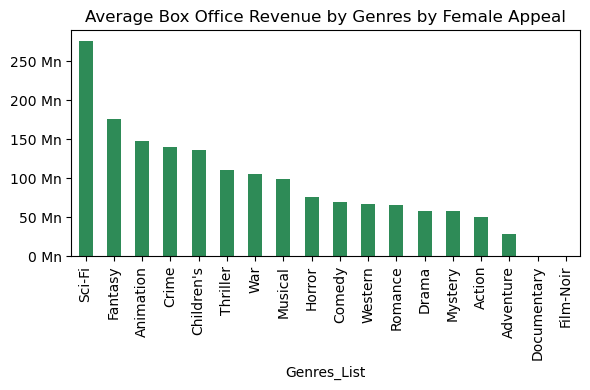

In [2113]:
female_pvt=pivot_table_Genre[['Female-Oriented Movie']]
female_pvt=female_pvt.sort_values(by="Female-Oriented Movie", ascending=False)

female_pvt.plot(kind='bar', figsize=(6, 4),legend=False, color="seagreen")

# Customizing the plot
plt.title("Average Box Office Revenue by Genres by Female Appeal", fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
# plt.xlabel("Genres", fontsize=8)
# plt.ylabel("Average Box Office Revenue", fontsize=8)
plt.xticks(rotation=90)
# plt.legend(title="Gendered Appeal")
plt.tight_layout()

# Show the plot
plt.show()

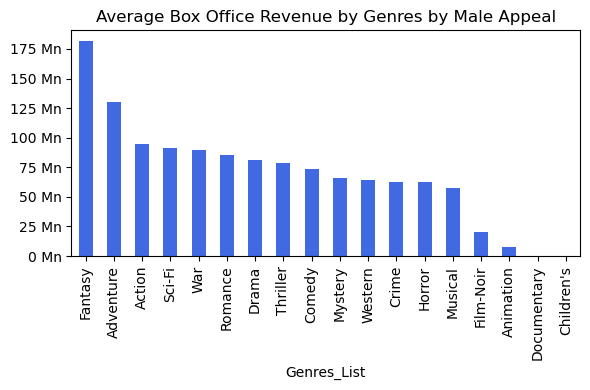

In [2114]:
male_pvt=pivot_table_Genre[['Male-Oriented Movie']]
male_pvt=male_pvt.sort_values(by="Male-Oriented Movie", ascending=False)

male_pvt.plot(kind='bar', figsize=(6, 4),legend=False,color='royalblue')

# Customizing the plot
plt.title("Average Box Office Revenue by Genres by Male Appeal", fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
# plt.xlabel("Genres", fontsize=8)
# plt.ylabel("Average Box Office Revenue", fontsize=8)
plt.xticks(rotation=90)
# plt.legend(title="Gendered Appeal")
plt.tight_layout()

# Show the plot
plt.show()

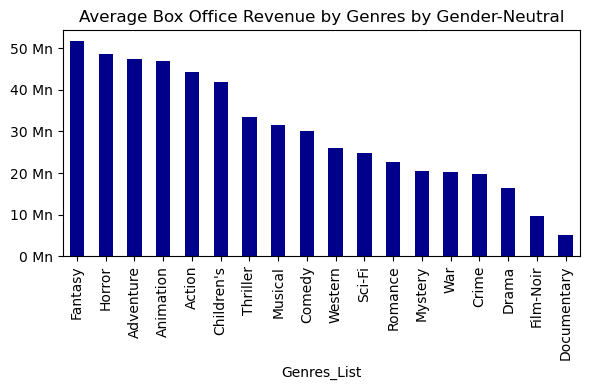

In [2115]:
gender_neutral_pvt=pivot_table_Genre[['Gender-Neutral Movie']]
gender_neutral_pvt=gender_neutral_pvt.sort_values(by="Gender-Neutral Movie", ascending=False)

gender_neutral_pvt.plot(kind='bar', figsize=(6, 4),legend=False,color="darkblue")

# Customizing the plot
plt.title("Average Box Office Revenue by Genres by Gender-Neutral", fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
# plt.xlabel("Genres", fontsize=8)
# plt.ylabel("Average Box Office Revenue", fontsize=8)
plt.xticks(rotation=90)
# plt.legend(title="Gendered Appeal")
plt.tight_layout()

# Show the plot
plt.show()

## Female oriented Movie

In [2118]:
top_gt3_female = pv_tbl_over_rated3.query("gendered_appeal=='Female-Oriented Movie'").sort_values(by=['scaled_weighted_diff'],ascending=False).head(10)
top_gt3_female.head(10)

,MovieID,Title_x,Genres,Released_Year,BoxOffice,Rated,avg_rating_F,avg_rating_M,rating_count_F,rating_count_M,total_avg_rating,tot_rating_count,scaled_weighted_avg_F,scaled_weighted_avg_M,scaled_weighted_avg,scaled_weighted_diff,gendered_appeal
16,17,Sense and Sensibility (1995),Drama|Romance,1996,43182776.0,PG,4.233333,3.819277,420.0,415.0,4.027545,835,0.862621,0.251178,0.401723,0.611443,Female-Oriented Movie
1490,2396,Shakespeare in Love (1998),Comedy|Romance,1999,100317794.0,R,4.181704,4.099936,798.0,1571.0,4.127480,2369,1.618991,1.020717,1.168020,0.598274,Female-Oriented Movie
608,920,Gone with the Wind (1939),Drama|Romance|War,1940,200882193.0,G,4.269841,3.829371,441.0,715.0,3.997405,1156,0.913563,0.433896,0.551996,0.479667,Female-Oriented Movie
269,357,Four Weddings and a Funeral (1994),Comedy|Romance,1994,52700832.0,R,3.834382,3.686508,477.0,756.0,3.743715,1233,0.887364,0.441661,0.551399,0.445703,Female-Oriented Movie
605,914,My Fair Lady (1964),Musical|Romance,1964,72560711.0,G,4.336667,3.991071,300.0,336.0,4.154088,636,0.631198,0.212511,0.315597,0.418687,Female-Oriented Movie
570,838,Emma (1996),Comedy|Drama|Romance,1996,22231658.0,PG,4.061151,3.654709,278.0,223.0,3.880240,501,0.547750,0.129155,0.232218,0.418595,Female-Oriented Movie
461,597,Pretty Woman (1990),Comedy|Romance,1990,178406268.0,R,3.846914,3.511700,405.0,641.0,3.641491,1046,0.755885,0.356720,0.455000,0.399165,Female-Oriented Movie
725,1188,Strictly Ballroom (1992),Comedy|Romance,1993,11738022.0,PG,4.174342,3.768817,304.0,372.0,3.951183,676,0.615673,0.222177,0.319061,0.393495,Female-Oriented Movie
30,34,Babe (1995),Children's|Comedy|Drama,1995,63658910.0,G,3.953368,3.860922,579.0,1172.0,3.891491,1751,1.110540,0.717085,0.813959,0.393455,Female-Oriented Movie
35,39,Clueless (1995),Comedy|Romance,1995,56631572.0,PG-13,3.827004,3.514640,474.0,888.0,3.623348,1362,0.880087,0.494591,0.589505,0.385496,Female-Oriented Movie


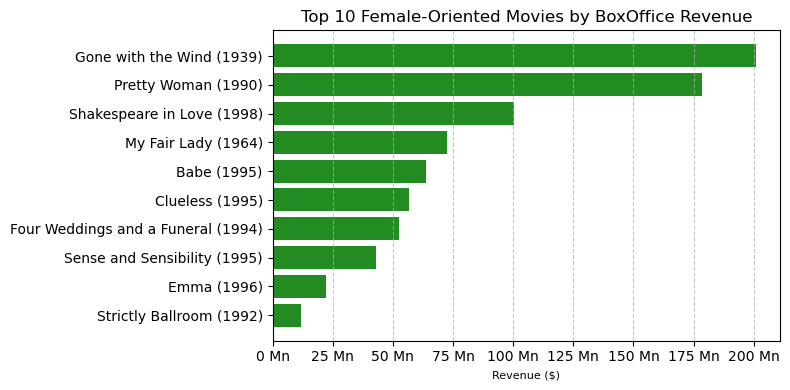

In [2119]:
# from matplotlib.ticker import ScalarFormatter
# Format axis labels to avoid scientific notation
# plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
# plt.gca().ticklabel_format(style='plain', axis='x')  # Ensure plain format for x-axis

# Custom formatter function for millions
def millions(x, pos):
    """The two args are the value and tick position."""
    return f'{x * 1e-6:.0f} Mn'
    
# Plot BoxOffice Revenue
top_gt3_female_boxoffice=top_gt3_female.sort_values(by=['BoxOffice'],ascending=True)
plt.figure(figsize=(8, 4))
plt.barh(top_gt3_female_boxoffice['Title_x'], top_gt3_female_boxoffice['BoxOffice'], color='forestgreen', label='BoxOffice Revenue')

# Apply the custom formatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))

plt.xlabel('Revenue ($)', fontsize=8)
# plt.ylabel('Movies', fontsize=12)
plt.title('Top 10 Female-Oriented Movies by BoxOffice Revenue', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

clear comparison of the financial success of each movie. Easy to compare which movies performed better financially.

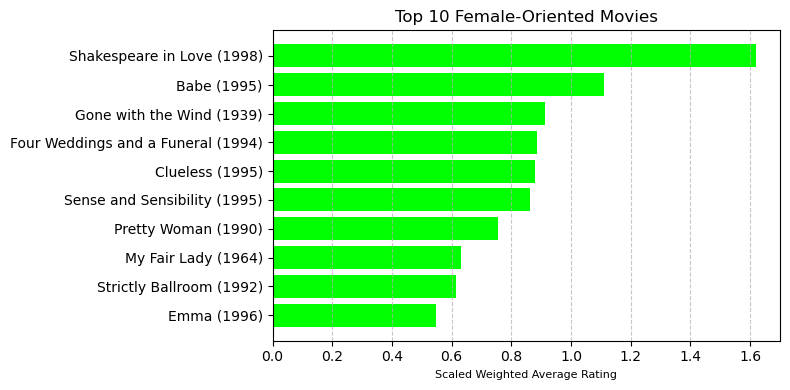

In [2121]:
top_gt3_female_rating=top_gt3_female.sort_values(by=['scaled_weighted_avg_F'],ascending=True)
plt.figure(figsize=(8, 4))
plt.barh(top_gt3_female_rating['Title_x'], top_gt3_female_rating['scaled_weighted_avg_F'], color='lime')#, label='Scaled Weighted Average Rating')

plt.xlabel('Scaled Weighted Average Rating', fontsize=8)
# plt.ylabel('Movies', fontsize=12)
plt.title('Top 10 Female-Oriented Movies', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Male oriented Movie

In [2126]:
top_gt3_male = pv_tbl_over_rated3.query("gendered_appeal=='Male-Oriented Movie'").sort_values(by=['scaled_weighted_diff'],ascending=True).head(10)
top_gt3_male.head(2)

,MovieID,Title_x,Genres,Released_Year,BoxOffice,Rated,avg_rating_F,avg_rating_M,rating_count_F,rating_count_M,total_avg_rating,tot_rating_count,scaled_weighted_avg_F,scaled_weighted_avg_M,scaled_weighted_avg,scaled_weighted_diff,gendered_appeal
454,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,1991,205881154.0,R,3.785088,4.115367,456.0,2193.0,4.058513,2649,0.837393,1.430208,1.284249,-0.592816,Male-Oriented Movie
735,1200,Aliens (1986),Action|Sci-Fi|Thriller|War,1986,85160248.0,R,3.802083,4.186684,288.0,1532.0,4.125824,1820,0.531254,1.016438,0.896979,-0.485184,Male-Oriented Movie


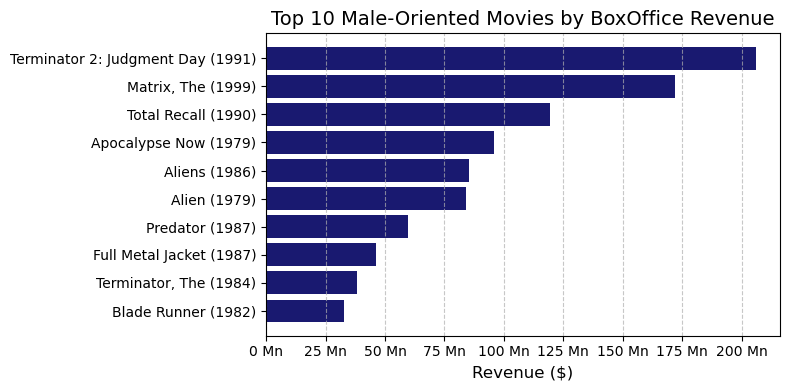

In [2127]:
# Plot BoxOffice Revenue
top_gt3_male_boxoffice=top_gt3_male.sort_values(by=['BoxOffice'],ascending=True)
plt.figure(figsize=(8, 4))
plt.barh(top_gt3_male_boxoffice['Title_x'], top_gt3_male_boxoffice['BoxOffice'], color='midnightblue', label='BoxOffice Revenue')

# Apply the custom formatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))

plt.xlabel('Revenue ($)', fontsize=12)
# plt.ylabel('Movies', fontsize=12)
plt.title('Top 10 Male-Oriented Movies by BoxOffice Revenue', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

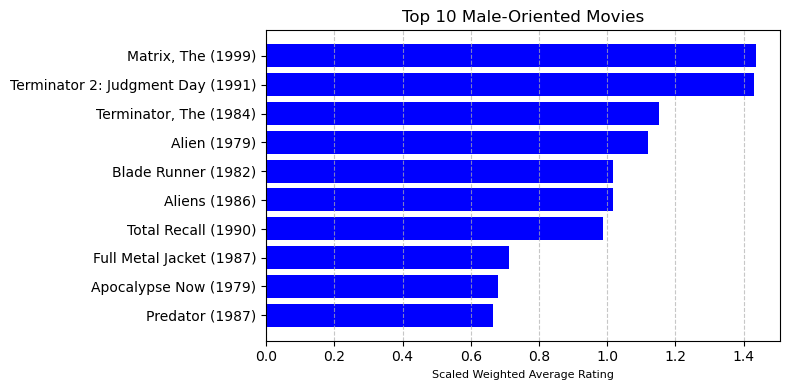

In [2128]:
top_gt3_male_rating=top_gt3_male.sort_values(by=['scaled_weighted_avg_M'],ascending=True)
plt.figure(figsize=(8, 4))
plt.barh(top_gt3_male_rating['Title_x'], top_gt3_male_rating['scaled_weighted_avg_M'], color='blue')#, label='Scaled Weighted Average Rating')

plt.xlabel('Scaled Weighted Average Rating', fontsize=8)
# plt.ylabel('Movies', fontsize=12)
plt.title('Top 10 Male-Oriented Movies', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Scaled Weighted Average by Gender for Top 10 Movies

In [2130]:
# Normalize scaled_weighted_avg column
pv_tbl_over_rated3['normalized_scaled_weighted_avg_M'] = (
    (pv_tbl_over_rated3['scaled_weighted_avg_M'] - pv_tbl_over_rated3['scaled_weighted_avg_M'].min()) /
    (pv_tbl_over_rated3['scaled_weighted_avg_M'].max() - pv_tbl_over_rated3['scaled_weighted_avg_M'].min())
)

pv_tbl_over_rated3['normalized_scaled_weighted_avg_F'] = (
    (pv_tbl_over_rated3['scaled_weighted_avg_F'] - pv_tbl_over_rated3['scaled_weighted_avg_F'].min()) /
    (pv_tbl_over_rated3['scaled_weighted_avg_F'].max() - pv_tbl_over_rated3['scaled_weighted_avg_F'].min())
)

# pv_tbl_over_rated3.sort_values(by=['scaled_weighted_avg'],ascending=False).head(10)
#same
top_movies = pv_tbl_over_rated3.nlargest(10, 'scaled_weighted_avg')  # Top 10 movies by overall scaled weighted average

C:\Users\hp\AppData\Local\Temp\ipykernel_15048\1152584306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_tbl_over_rated3['normalized_scaled_weighted_avg_M'] = (
C:\Users\hp\AppData\Local\Temp\ipykernel_15048\1152584306.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_tbl_over_rated3['normalized_scaled_weighted_avg_F'] = (


In [2131]:
top_movies[['Title_x','normalized_scaled_weighted_avg_F','normalized_scaled_weighted_avg_M','scaled_weighted_avg_F','scaled_weighted_avg_M']]

,Title_x,normalized_scaled_weighted_avg_F,normalized_scaled_weighted_avg_M,scaled_weighted_avg_F,scaled_weighted_avg_M
1775,American Beauty (1999),1.000000,1.000000,1.945506,1.709911
199,Star Wars: Episode IV - A New Hope (1977),0.694188,0.976546,1.350696,1.669818
731,Star Wars: Episode V - The Empire Strikes Back...,0.663507,0.942987,1.291021,1.612451
740,Star Wars: Episode VI - Return of the Jedi (1983),0.629334,0.840920,1.224553,1.437973
1257,Saving Private Ryan (1998),0.589923,0.847131,1.147897,1.448591
733,Raiders of the Lost Ark (1981),0.617860,0.813572,1.202236,1.391224
457,"Silence of the Lambs, The (1991)",0.752058,0.760174,1.463254,1.299944
1620,"Matrix, The (1999)",0.529060,0.839251,1.029517,1.435121
1720,"Sixth Sense, The (1999)",0.741332,0.728562,1.442392,1.245905
454,Terminator 2: Judgment Day (1991),0.430282,0.836377,0.837393,1.430208


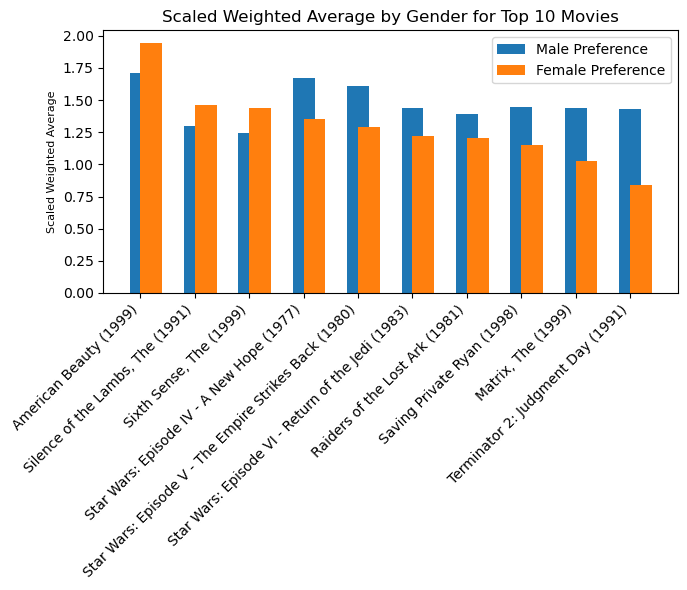

In [2132]:
top_movies_sorting = top_movies.sort_values(by=['scaled_weighted_avg_F'],ascending=False)
# Plot bar chart for scaled_weighted_avg_M and scaled_weighted_avg_F
plt.figure(figsize=(7, 6))
x = range(len(top_movies_sorting))

# Plot for Male and Female Preferences
plt.bar(x, top_movies_sorting['scaled_weighted_avg_M'], width=0.4, label='Male Preference', align='center')
plt.bar(x, top_movies_sorting['scaled_weighted_avg_F'], width=0.4, label='Female Preference', align='edge')

# Add labels and legend
plt.xticks(x, top_movies_sorting['Title_x'], rotation=45, ha='right')
plt.ylabel('Scaled Weighted Average',fontsize=8)
plt.title('Scaled Weighted Average by Gender for Top 10 Movies',fontsize=12)
plt.legend()

# Show plot
plt.tight_layout()
plt.savefig('Scaled Weighted Average by Gender for Top 10 Movies.png', bbox_inches='tight')
plt.show()


## Most equal range of ages by Top 10 movie

In [2134]:
merged_omdb_age = merged_omdb_df.copy()
merged_omdb_age.shape

(919556, 31)

In [2135]:
# merged_omdb_age.groupby(['Age'])["UserID"].count()

In [2136]:
def categorize_age(Age):
    if Age == 1:
        return 'Teenager (Under 18)'
    elif 18 <= Age <= 25:
        return 'Young Adult (18-34)'
    elif 35 <= Age <= 50:
        return 'Middle-Aged Adult (35-55)'
    elif Age >= 56:
        return 'Older Adult (56+)'
    else:
        return 'Unknown'  # Optional: Handle unexpected values

age_labels = ['Teenager (Under 18)','Young Adult (18-34)','Middle-Aged Adult (35-55)','Older Adult (56+)']
# Apply the function to the Age column
merged_omdb_age['Age_Group'] = merged_omdb_age['Age'].apply(categorize_age)

In [2137]:
# merged_omdb_age.groupby(['Age_Group'])["UserID"].nunique()

In [2138]:
merged_omdb_age.groupby(['Age_Group'])["Rating"].mean()

Age_Group
Middle-Aged Adult (35-55)    3.635686
Older Adult (56+)            3.759933
Teenager (Under 18)          3.545512
Young Adult (18-34)          3.525170
Name: Rating, dtype: float64

In [2139]:
merged_omdb_age[merged_omdb_age['Rating'] <1]

,UserID,MovieID,Rating,Timestamp,Date,RatingYear,Title_x,Genres,Movie_Year,Gender,Age,Occupation,Zip-code,Age_Group,Title_y,Year,Rated,Released,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,imdbRating,Type,BoxOffice,Released_Year


In [2140]:
merged_omdb_age.shape

(919556, 31)

In [2145]:
age_grp_rating = merged_omdb_age.groupby(['MovieID','Title_x','Genres','Released_Year','Rated','BoxOffice','Age_Group']) \
    .agg(
        avg_rating=('Rating', 'mean'),
        rating_count=('Rating', 'count')
    ).reset_index()
age_grp_rating.head()

,MovieID,Title_x,Genres,Released_Year,Rated,BoxOffice,Age_Group,avg_rating,rating_count
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,G,223225679.0,Middle-Aged Adult (35-55),4.227003,674
1,1,Toy Story (1995),Animation|Children's|Comedy,1995,G,223225679.0,Older Adult (56+),3.886792,53
2,1,Toy Story (1995),Animation|Children's|Comedy,1995,G,223225679.0,Teenager (Under 18),3.919643,112
3,1,Toy Story (1995),Animation|Children's|Comedy,1995,G,223225679.0,Young Adult (18-34),4.134895,1238
4,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,PG,100499940.0,Middle-Aged Adult (35-55),3.354167,240


In [2146]:
avg_rating_by_movie=merged_omdb_age.groupby(['MovieID'])['Rating'].mean()

In [2147]:
age_pivot_table_df = age_grp_rating.pivot_table(
    index=['MovieID','Title_x','Genres','Released_Year','BoxOffice','Rated'],
    columns='Age_Group',
    values=['avg_rating'],#, 'rating_count'],
    # fill_value=0
)
age_pivot_table_df.columns = [f'{col[0]}_{col[1]}' for col in age_pivot_table_df.columns]
age_pivot_table_df = age_pivot_table_df.reset_index()
age_pivot_table_df.columns

Index(['MovieID', 'Title_x', 'Genres', 'Released_Year', 'BoxOffice', 'Rated',
       'avg_rating_Middle-Aged Adult (35-55)', 'avg_rating_Older Adult (56+)',
       'avg_rating_Teenager (Under 18)', 'avg_rating_Young Adult (18-34)'],
      dtype='object')

In [2148]:
avg_rating_col = ['avg_rating_Teenager (Under 18)','avg_rating_Young Adult (18-34)','avg_rating_Middle-Aged Adult (35-55)','avg_rating_Older Adult (56+)']

In [2149]:
# test = age_pivot_table_df.query("MovieID==13")
# test[avg_rating_col].std(axis=1)

In [2150]:
age_pivot_table_df['range'] = age_pivot_table_df[avg_rating_col].max(axis=1) - age_pivot_table_df[avg_rating_col].min(axis=1)
age_pivot_table_df['StdDev'] = age_pivot_table_df[avg_rating_col].std(axis=1)

In [2151]:
age_pivot_table_df.head(3)

,MovieID,Title_x,Genres,Released_Year,BoxOffice,Rated,avg_rating_Middle-Aged Adult (35-55),avg_rating_Older Adult (56+),avg_rating_Teenager (Under 18),avg_rating_Young Adult (18-34),range,StdDev
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,223225679.0,G,4.227003,3.886792,3.919643,4.134895,0.340211,0.165243
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,100499940.0,PG,3.354167,3.500000,3.388889,3.089157,0.410843,0.174088
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,71518503.0,PG-13,2.979592,2.933333,3.500000,3.014134,0.566667,0.264238


In [2152]:
age_pivot_table_new = age_pivot_table_df.merge(avg_rating_by_movie, on="MovieID")

In [2153]:
age_pivot_table_new['rating_not_null_count'] = age_pivot_table_new[avg_rating_col].notnull().sum(axis=1)
# age_pivot_table_new=age_pivot_table_new.reset_index()

In [2154]:
age_pivot_table_new.head(2)

,MovieID,Title_x,Genres,Released_Year,BoxOffice,Rated,avg_rating_Middle-Aged Adult (35-55),avg_rating_Older Adult (56+),avg_rating_Teenager (Under 18),avg_rating_Young Adult (18-34),range,StdDev,Rating,rating_not_null_count
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,223225679.0,G,4.227003,3.886792,3.919643,4.134895,0.340211,0.165243,4.146846,4
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,100499940.0,PG,3.354167,3.500000,3.388889,3.089157,0.410843,0.174088,3.201141,4


In [2155]:
age_pivot_table_new.groupby(['rating_not_null_count'])['MovieID'].count().reset_index()

,rating_not_null_count,MovieID
0,1,9
1,2,147
2,3,460
3,4,1771


We have 4 age group and all moive have rated by user which has separate age group.
We have 1771 movies which have got rating from all age group by user. We will find which movie will have most equal range of ages sorting by their variation using standard deviation.

In [2157]:
age_group_four = age_pivot_table_new[age_pivot_table_new["rating_not_null_count"]==4]
age_group_three = age_pivot_table_new.query("rating_not_null_count==3")
age_group_two = age_pivot_table_new.query("rating_not_null_count==2")
age_group_one = age_pivot_table_new.query("rating_not_null_count==1")

In [2158]:
# age_group_four = age_group_four.sort_values(by=['StdDev'],ascending=True)
# age_group_four

In [2159]:
age_group_four[['Rating','StdDev']].describe()

,Rating,StdDev
count,1771.000000,1771.000000
mean,3.316327,0.346897
std,0.566922,0.255339
min,1.611111,0.008795
25%,2.941489,0.168197
50%,3.371274,0.273592
75%,3.738459,0.444076
max,4.608696,1.732051


In [2160]:
rating_percentile = age_group_four["Rating"].quantile(0.50)
top10_rating_four=age_group_four[age_group_four['Rating']>rating_percentile].sort_values(by=['StdDev'],ascending=True).head(10)
top10_rating_four

,MovieID,Title_x,Genres,Released_Year,BoxOffice,Rated,avg_rating_Middle-Aged Adult (35-55),avg_rating_Older Adult (56+),avg_rating_Teenager (Under 18),avg_rating_Young Adult (18-34),range,StdDev,Rating,rating_not_null_count
1412,2294,Antz (1998),Animation|Children's,1998,90757863.0,PG,3.483871,3.466667,3.473684,3.485222,0.018555,0.008795,3.483721,4
1809,2908,Boys Don't Cry (1999),Drama,2000,11540607.0,R,4.022222,3.973684,4.000000,4.013462,0.048538,0.021179,4.014118,4
2268,3730,"Conversation, The (1974)",Drama|Mystery,1974,4824093.0,PG,4.268293,4.219512,4.250000,4.227848,0.048780,0.022060,4.249448,4
1858,2997,Being John Malkovich (1999),Comedy,1999,22863596.0,R,4.117052,4.149425,4.090909,4.129656,0.058516,0.024506,4.125390,4
1205,1956,Ordinary People (1980),Drama,1980,54766923.0,R,3.970909,3.966667,4.000000,4.020000,0.053333,0.025215,3.990138,4
1272,2058,"Negotiator, The (1998)",Action|Thriller,1998,44547681.0,R,3.614719,3.647059,3.578947,3.605263,0.068111,0.028127,3.608260,4
2159,3527,Predator (1987),Action|Sci-Fi|Thriller,1987,59735548.0,R,3.673660,3.642857,3.600000,3.645122,0.073660,0.030368,3.653816,4
793,1287,Ben-Hur (1959),Action|Adventure|Drama,1959,74432704.0,G,4.127536,4.098039,4.045455,4.097902,0.082082,0.034158,4.110795,4
89,111,Taxi Driver (1976),Drama|Thriller,1976,28262574.0,R,4.167702,4.244898,4.227273,4.189504,0.077196,0.035106,4.183871,4
411,529,Searching for Bobby Fischer (1993),Drama,1993,7266383.0,PG,3.969582,3.962963,3.904762,3.987775,0.083013,0.035906,3.977778,4


In [2161]:
age_group_three[['Rating','StdDev']].describe()

,Rating,StdDev
count,460.000000,460.000000
mean,2.980998,0.448753
std,0.596965,0.312699
min,1.000000,0.000000
25%,2.570463,0.226342
50%,3.047140,0.371936
75%,3.401562,0.577633
max,4.444444,2.081666


In [2162]:
rating_percentile = age_group_three["Rating"].quantile(0.50)
top10_rating_three=age_group_three[age_group_three['Rating']>rating_percentile].sort_values(by=['StdDev'],ascending=True).head(10)
top10_rating_three

,MovieID,Title_x,Genres,Released_Year,BoxOffice,Rated,avg_rating_Middle-Aged Adult (35-55),avg_rating_Older Adult (56+),avg_rating_Teenager (Under 18),avg_rating_Young Adult (18-34),range,StdDev,Rating,rating_not_null_count
2230,3682,Magnum Force (1973),Western,1973,39768000.0,R,3.664122,3.750000,NaN,3.731343,0.085878,0.045170,3.690476,3
228,304,Roommates (1995),Comedy|Drama,1995,12096881.0,PG,3.083333,3.166667,NaN,3.176471,0.093137,0.051178,3.142857,3
1185,1910,I Went Down (1997),Action|Comedy|Crime,1998,405297.0,R,3.769231,NaN,3.666667,3.760000,0.102564,0.056739,3.756098,3
596,896,Wild Reeds (1994),Drama,1995,807775.0,Not Rated,3.444444,3.333333,NaN,3.433333,0.111111,0.061195,3.431373,3
1110,1788,Men With Guns (1997),Action|Drama,1998,910773.0,R,4.028571,4.000000,NaN,3.905660,0.122911,0.064321,3.956044,3
2063,3370,Betrayed (1988),Drama|Thriller,1988,25816139.0,R,3.468085,3.333333,NaN,3.388889,0.134752,0.067721,3.430233,3
1342,2151,"Gods Must Be Crazy II, The (1989)",Comedy,1990,6291444.0,PG,3.250000,3.166667,NaN,3.114286,0.135714,0.068443,3.171875,3
2096,3427,Coogan's Bluff (1968),Crime,1968,3110000.0,Approved,3.333333,3.250000,NaN,3.388889,0.138889,0.069906,3.337838,3
1173,1889,Insomnia (1997),Thriller,1998,227569.0,Not Rated,3.928571,NaN,4.000000,3.852941,0.147059,0.073539,3.877551,3
1990,3230,"Odessa File, The (1974)",Thriller,1974,1113301.0,PG,3.650000,3.800000,NaN,3.692308,0.150000,0.077339,3.666667,3


In [2163]:
age_group_two[['Rating','StdDev']].describe()

,Rating,StdDev
count,147.000000,147.000000
mean,2.967543,0.413294
std,0.654955,0.384372
min,1.372093,0.000000
25%,2.525045,0.143144
50%,3.000000,0.294628
75%,3.476842,0.565685
max,4.500000,2.121320


In [2164]:
rating_percentile = age_group_two["Rating"].quantile(0.50)
top10_rating_two=age_group_two[age_group_two['Rating']>rating_percentile].sort_values(by=['StdDev'],ascending=True).head(10)
top10_rating_two

,MovieID,Title_x,Genres,Released_Year,BoxOffice,Rated,avg_rating_Middle-Aged Adult (35-55),avg_rating_Older Adult (56+),avg_rating_Teenager (Under 18),avg_rating_Young Adult (18-34),range,StdDev,Rating,rating_not_null_count
1142,1842,Illtown (1996),Crime|Drama,1998,14478.0,R,4.000000,NaN,NaN,4.000000,0.000000,0.000000,4.000000,2
1462,2358,Savior (1998),Drama,1998,14328.0,R,4.000000,NaN,NaN,4.000000,0.000000,0.000000,4.000000,2
872,1412,Some Mother's Son (1996),Drama,1996,671437.0,R,3.900000,NaN,NaN,3.900000,0.000000,0.000000,3.900000,2
284,375,Safe Passage (1994),Drama,1995,1618282.0,PG-13,3.333333,NaN,NaN,3.285714,0.047619,0.033672,3.294118,2
1625,2579,Following (1998),Drama,1999,48482.0,R,3.833333,NaN,NaN,3.782609,0.050725,0.035868,3.793103,2
1196,1922,Whatever (1998),Drama,1998,307037.0,R,3.461538,NaN,NaN,3.410256,0.051282,0.036262,3.423077,2
1954,3161,Onegin (1999),Drama,1999,206128.0,R,3.428571,NaN,NaN,3.500000,0.071429,0.050508,3.473684,2
958,1546,Schizopolis (1996),Comedy,1997,10580.0,Not Rated,3.750000,NaN,NaN,3.829268,0.079268,0.056051,3.816327,2
1985,3218,Poison (1991),Drama,1991,787280.0,Unrated,3.142857,NaN,NaN,3.222222,0.079365,0.056120,3.187500,2
442,567,Kika (1993),Drama,1994,2019581.0,Unrated,3.500000,NaN,NaN,3.583333,0.083333,0.058926,3.571429,2


In [2165]:
top10_rating_one=age_group_one.sort_values(by=['StdDev'],ascending=True)
top10_rating_one

,MovieID,Title_x,Genres,Released_Year,BoxOffice,Rated,avg_rating_Middle-Aged Adult (35-55),avg_rating_Older Adult (56+),avg_rating_Teenager (Under 18),avg_rating_Young Adult (18-34),range,StdDev,Rating,rating_not_null_count
500,687,Country Life (1994),Drama|Romance,1995,350354.0,PG-13,3.0,NaN,NaN,NaN,0.0,NaN,3.000000,1
622,981,Dangerous Ground (1997),Drama,1997,5303931.0,R,NaN,NaN,NaN,2.750000,0.0,NaN,2.750000,1
1603,2543,Six Ways to Sunday (1997),Comedy,1999,54751.0,R,NaN,NaN,NaN,3.500000,0.0,NaN,3.500000,1
1638,2608,Heaven (1998),Thriller,1999,2838.0,R,NaN,NaN,NaN,2.600000,0.0,NaN,2.600000,1
1674,2695,"Boys, The (1997)",Drama,1997,4602341.0,Not Rated,NaN,NaN,NaN,2.181818,0.0,NaN,2.181818,1
1958,3166,Brenda Starr (1989),Adventure,1992,67878.0,PG,NaN,NaN,NaN,1.166667,0.0,NaN,1.166667,1
1989,3228,Wirey Spindell (1999),Comedy,2000,9838.0,Not Rated,1.0,NaN,NaN,NaN,0.0,NaN,1.000000,1
2103,3437,Cool as Ice (1991),Drama,1991,1193062.0,PG,NaN,NaN,NaN,2.000000,0.0,NaN,2.000000,1
2197,3609,Regret to Inform (1998),Documentary,0,44204.0,Not Rated,4.0,NaN,NaN,NaN,0.0,NaN,4.000000,1


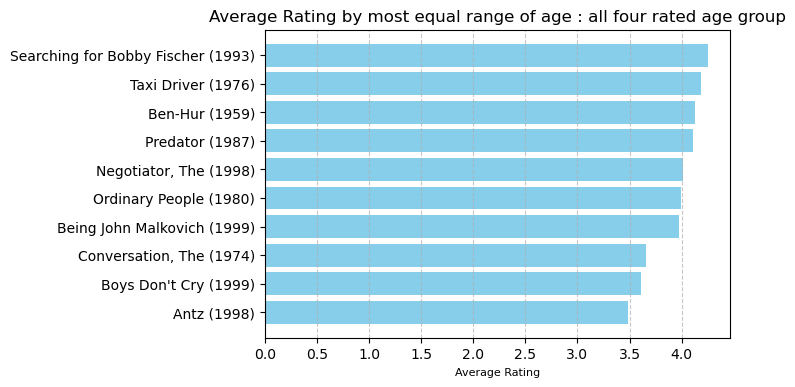

In [2166]:
movie_titles = top10_rating_four['Title_x']
ratings = top10_rating_four['Rating'].sort_values(ascending=True)

# Plot the sorted ratings
plt.figure(figsize=(6, 4))
plt.barh(movie_titles, ratings, color='skyblue')
plt.xlabel('Average Rating',fontsize=8)
plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.ylabel('Movie Titles')
plt.title('Average Rating by most equal range of age : all four rated age group',fontsize=12) ##defined by less variation
# plt.gca().invert_yaxis()  # Invert the y-axis for a top-down ranking view
plt.show()

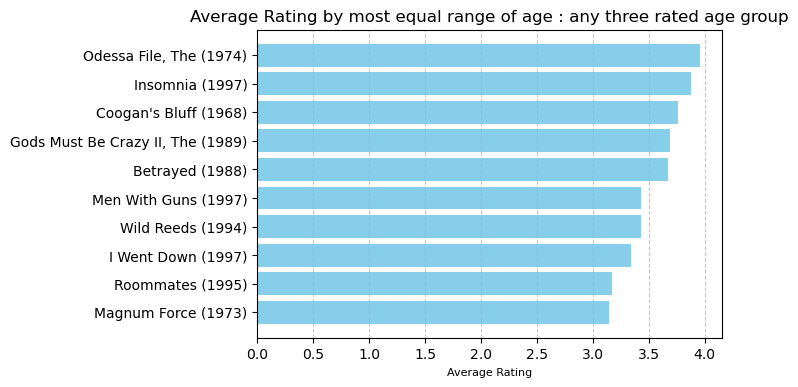

In [2167]:
movie_titles = top10_rating_three['Title_x']
ratings = top10_rating_three['Rating'].sort_values(ascending=True)

# Plot the sorted ratings
plt.figure(figsize=(6, 4))
plt.barh(movie_titles, ratings, color='skyblue')
plt.xlabel('Average Rating',fontsize=8)
plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.ylabel('Movie Titles')
plt.title('Average Rating by most equal range of age : any three rated age group',fontsize=12) ##defined by less variation
# plt.gca().invert_yaxis()  # Invert the y-axis for a top-down ranking view
plt.show()

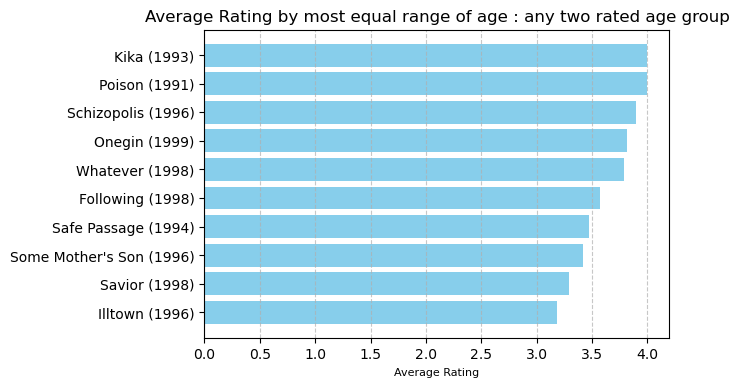

In [2168]:
movie_titles = top10_rating_two['Title_x']
ratings = top10_rating_two['Rating'].sort_values(ascending=True)

# Plot the sorted ratings
plt.figure(figsize=(6, 4))
plt.barh(movie_titles, ratings, color='skyblue')
plt.xlabel('Average Rating',fontsize=8)
plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.ylabel('Movie Titles')
plt.title('Average Rating by most equal range of age : any two rated age group',fontsize=12) ##defined by less variation
# plt.gca().invert_yaxis()  # Invert the y-axis for a top-down ranking view
plt.show()

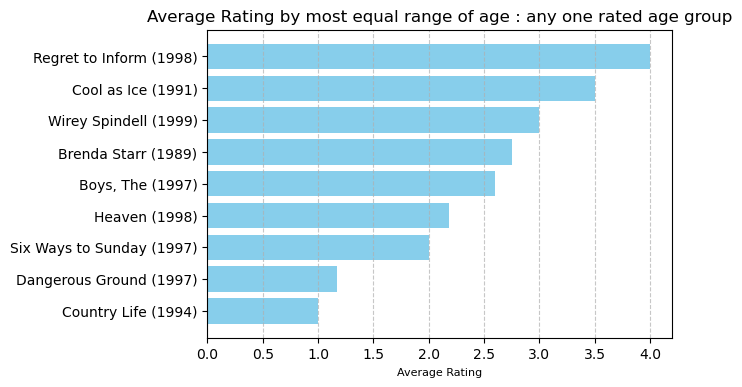

In [2169]:
movie_titles = top10_rating_one['Title_x']
ratings = top10_rating_one['Rating'].sort_values(ascending=True)

# Plot the sorted ratings
plt.figure(figsize=(6, 4))
plt.barh(movie_titles, ratings, color='skyblue')
plt.xlabel('Average Rating',fontsize=8)
plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.ylabel('Movie Titles')
plt.title('Average Rating by most equal range of age : any one rated age group',fontsize=12) ##defined by less variation
# plt.gca().invert_yaxis()  # Invert the y-axis for a top-down ranking view
plt.show()

### Prediction audiences' demographics 

Research Question - 2.	Can a classification model predict gender and age based on movie preferences and behaviour?

In [2172]:
all_data = merged_omdb_age.copy()
all_data.head(2)

,UserID,MovieID,Rating,Timestamp,Date,RatingYear,Title_x,Genres,Movie_Year,Gender,Age,Occupation,Zip-code,Age_Group,Title_y,Year,Rated,Released,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,imdbRating,Type,BoxOffice,Released_Year
0,1,1193,5,2000-12-31 22:12:40,2000-12-31,2000,One Flew Over the Cuckoo's Nest (1975),Drama,1975,F,1,10,48067,Teenager (Under 18),One Flew Over the Cuckoo's Nest,1975,R,1975-11-19,Drama,Milos Forman,"Lawrence Hauben, Bo Goldman, Ken Kesey","Jack Nicholson, Louise Fletcher, Michael Berryman",McMurphy has a criminal past and has once agai...,English,United States,Won 5 Oscars. 38 wins & 15 nominations total,https://m.media-amazon.com/images/M/MV5BYjBkMj...,8.7,movie,108981275.0,1975
1,1,661,3,2000-12-31 22:35:09,2000-12-31,2000,James and the Giant Peach (1996),Animation|Children's|Musical,1996,F,1,10,48067,Teenager (Under 18),James and the Giant Peach,1996,PG,1996-04-12,"Animation, Adventure, Family",Henry Selick,"Roald Dahl, Karey Kirkpatrick, Jonathan Roberts","Paul Terry, Joanna Lumley, Pete Postlethwaite",James' happy life at the English seaside is ru...,English,"United Kingdom, United States",Nominated for 1 Oscar. 4 wins & 13 nominations...,https://m.media-amazon.com/images/M/MV5BMmQwND...,6.7,movie,28946127.0,1996


### Feature Engineering

In [2174]:
# Split Genres into multiple columns (one-hot encoding)
genre_columns = all_data['Genres'].str.get_dummies(sep='|')
print(genre_columns)

        Action  Adventure  Animation  Children's  Comedy  Crime  Documentary  \
0            0          0          0           0       0      0            0   
1            0          0          1           1       0      0            0   
2            0          0          0           0       0      0            0   
3            0          0          0           0       0      0            0   
4            1          1          0           0       1      0            0   
...        ...        ...        ...         ...     ...    ...          ...   
919551       0          0          0           0       1      0            0   
919552       0          0          0           0       0      0            0   
919553       0          0          0           0       1      0            0   
919554       0          0          0           0       0      0            0   
919555       0          0          0           1       0      0            0   

        Drama  Fantasy  Film-Noir  Horr

In [2175]:
all_data = pd.concat([all_data, genre_columns], axis=1)

In [2176]:
all_data.head(2)

,UserID,MovieID,Rating,Timestamp,Date,RatingYear,Title_x,Genres,Movie_Year,Gender,Age,Occupation,Zip-code,Age_Group,Title_y,Year,Rated,Released,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,imdbRating,Type,BoxOffice,Released_Year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1193,5,2000-12-31 22:12:40,2000-12-31,2000,One Flew Over the Cuckoo's Nest (1975),Drama,1975,F,1,10,48067,Teenager (Under 18),One Flew Over the Cuckoo's Nest,1975,R,1975-11-19,Drama,Milos Forman,"Lawrence Hauben, Bo Goldman, Ken Kesey","Jack Nicholson, Louise Fletcher, Michael Berryman",McMurphy has a criminal past and has once agai...,English,United States,Won 5 Oscars. 38 wins & 15 nominations total,https://m.media-amazon.com/images/M/MV5BYjBkMj...,8.7,movie,108981275.0,1975,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,661,3,2000-12-31 22:35:09,2000-12-31,2000,James and the Giant Peach (1996),Animation|Children's|Musical,1996,F,1,10,48067,Teenager (Under 18),James and the Giant Peach,1996,PG,1996-04-12,"Animation, Adventure, Family",Henry Selick,"Roald Dahl, Karey Kirkpatrick, Jonathan Roberts","Paul Terry, Joanna Lumley, Pete Postlethwaite",James' happy life at the English seaside is ru...,English,"United Kingdom, United States",Nominated for 1 Oscar. 4 wins & 13 nominations...,https://m.media-amazon.com/images/M/MV5BMmQwND...,6.7,movie,28946127.0,1996,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [2177]:
# 3. Demographic Groups
# Grouping by age groups and gender to calculate average ratings
demographic_avg_rating = all_data.groupby(['Age_Group', 'Gender'])['Rating'].mean().rename('DemoAvgRating')
demographic_avg_rating

Age_Group                  Gender
Middle-Aged Adult (35-55)  F         3.679411
                           M         3.620453
Older Adult (56+)          F         3.916417
                           M         3.711508
Teenager (Under 18)        F         3.616167
                           M         3.511520
Young Adult (18-34)        F         3.547791
                           M         3.518163
Name: DemoAvgRating, dtype: float64

In [2178]:
# Rating recency: most recent rating timestamp
rating_recency = all_data.groupby('UserID')['Date'].max().rename('RatingRecency')
rating_recency.head()

UserID
1    2001-01-06
2    2000-12-31
3    2000-12-31
4    2000-12-31
5    2000-12-31
Name: RatingRecency, dtype: object

In [2179]:
# Rating diversity: unique genres rated by user
user_genre_diversity = all_data.groupby('UserID')[genre_columns.columns].sum().gt(0).sum(axis=1).reset_index().rename(columns={0: 'GenreDiversity'})
user_genre_diversity.head()

,UserID,GenreDiversity
0,1,13
1,2,14
2,3,15
3,4,10
4,5,17


In [2180]:
# Average rating by user
rating_df = all_data.groupby(['UserID']) \
    .agg(
        avg_rating=('Rating', 'mean'),
        median_rating=('Rating', 'median'),
        rating_variance=('Rating', 'var'),
        rating_count=('Rating', 'count'), #Behavioral Features
        std_rating=('Rating', 'std')
    ).fillna(0).reset_index()
print(rating_df.shape)
rating_df.head()

(6040, 6)


,UserID,avg_rating,median_rating,rating_variance,rating_count,std_rating
0,1,4.183673,4.0,0.444728,49,0.666879
1,2,3.705882,4.0,1.056830,119,1.028022
2,3,3.833333,4.0,0.950355,48,0.974861
3,4,4.111111,4.0,1.281046,18,1.131833
4,5,3.160000,3.0,1.296092,175,1.138460


In [2181]:
# Rating Distribution (Percentage of each rating level)
rating_distribution = (
    all_data.groupby(['UserID', 'Rating'])
    .size() #Count the number of occurrences for each group.
    .unstack(fill_value=0) #Reshape the grouped data to have 'Rating' as columns and fill missing values with 0.
    .apply(lambda x: x / x.sum(), axis=1) #Normalize the rows so that the sum of each row equals 1 (proportion of each rating).
    .reset_index() #Reset the index to make 'UserID' a column again.
)
print(rating_distribution.shape)
rating_distribution.head()

(6040, 6)


Rating,UserID,1,2,3,4,5
0,1,0.000000,0.000000,0.142857,0.530612,0.326531
1,2,0.016807,0.092437,0.336134,0.277311,0.277311
2,3,0.020833,0.083333,0.187500,0.458333,0.250000
3,4,0.055556,0.055556,0.055556,0.388889,0.444444
4,5,0.097143,0.177143,0.302857,0.314286,0.108571


User 1 gave 14.28% of their ratings as 2, 53.06% as 4, and 32.65% as 5.

In [2183]:
user_1_ratings = rating_distribution[rating_distribution['UserID'] == 1]
print(user_1_ratings)

Rating  UserID    1    2         3         4         5
0            1  0.0  0.0  0.142857  0.530612  0.326531


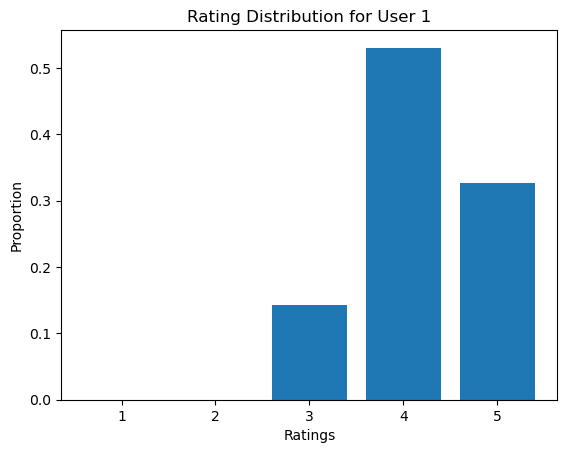

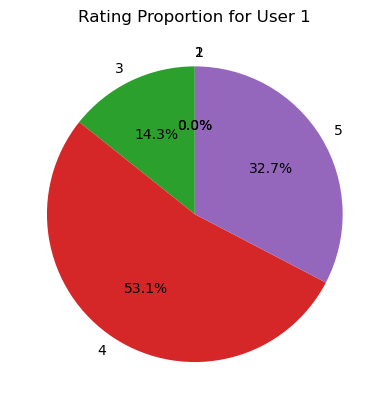

In [2184]:
# Extract data for User 1 (excluding the 'UserID' column)
user_1_data = user_1_ratings.iloc[0, 1:]  # Assuming the first row corresponds to User 1

# Bar Chart
plt.bar(user_1_data.index, user_1_data.values)
plt.title("Rating Distribution for User 1")
plt.xlabel("Ratings")
plt.ylabel("Proportion")
plt.show()

# Pie Chart
plt.pie(user_1_data.values, labels=user_1_data.index, autopct='%1.1f%%', startangle=90)
plt.title("Rating Proportion for User 1")
plt.show()

In [2185]:
#To understand the number of ratings User 1 gave for each rating, you can use the original grouped data:
total_ratings = all_data.groupby(['UserID', 'Rating']).size().unstack(fill_value=0)
user_1_total = total_ratings.loc[1]  # Get counts for User 1
print(user_1_total)

Rating
1     0
2     0
3     7
4    26
5    16
Name: 1, dtype: int64


In [2186]:
#Identify Preferences - calculate the rating with the highest proportion to identify the user's most frequent rating:
most_common_rating = user_1_data.idxmax()
print(f"User 1's most common rating is {most_common_rating}.")

User 1's most common rating is 4.


If User 1's rating distribution shows a preference for higher ratings (e.g., "4" and "5"), they might generally enjoy the movies they watch. If they rate consistently lower than the average, they may be a critical reviewer.

In [2188]:
#Compare User 1 with Others
average_distribution = rating_distribution.mean(axis=0)  # Mean proportion of ratings across all users
print("Average Rating Distribution Across All Users:")
print(average_distribution)

print("\nComparison for User 1:")
print(user_1_data - average_distribution[1:])  # Subtract User 1's distribution from the average


Average Rating Distribution Across All Users:
Rating
UserID    3020.500000
1            0.048864
2            0.092815
3            0.237772
4            0.352732
5            0.267818
dtype: float64

Comparison for User 1:
Rating
1   -0.048864
2   -0.092815
3   -0.094915
4    0.177880
5    0.058713
dtype: float64


In [2189]:
# To gain more context, you can look at the specific movies User 1 rated with each rating:
user_1_movies = all_data[all_data['UserID'] == 1]
print(user_1_movies.groupby('Rating')['MovieID'].apply(list))

Rating
3              [661, 914, 1197, 2687, 2321, 720, 2340]
4    [3408, 594, 919, 938, 2398, 2918, 2791, 2018, ...
5    [1193, 1287, 595, 1035, 3105, 1270, 527, 48, 1...
Name: MovieID, dtype: object


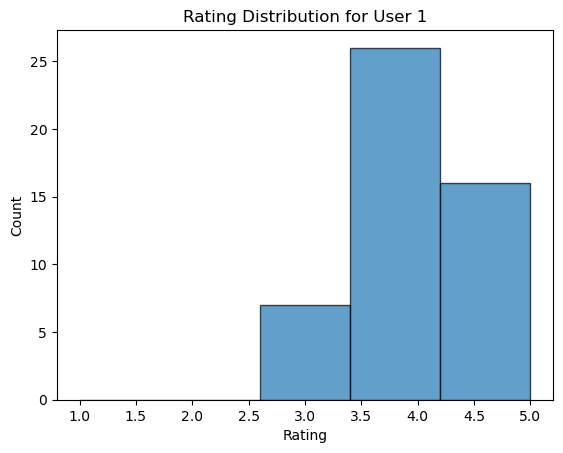

In [2190]:
# Visualize Rating Distribution for a Specific User (Example: UserID 1)
user_id = 1
user_ratings = all_data[all_data['UserID'] == user_id]['Rating']
plt.hist(user_ratings, bins=5, range=(1, 5), edgecolor='black', alpha=0.7)
plt.title(f'Rating Distribution for User {user_id}')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Cluster the user group

In [2193]:
# Calculate Skewness, Kurtosis, and Entropy for each user's rating distribution
rating_distribution['Skewness'] = rating_distribution.iloc[:, 1:].apply(
    lambda x: skew(x.fillna(0), nan_policy='omit'), axis=1
).replace([np.inf, -np.inf], np.nan).fillna(0)
rating_distribution['Kurtosis'] = rating_distribution.iloc[:, 1:].apply(
    lambda x: kurtosis(x.fillna(0), nan_policy='omit'), axis=1
).replace([np.inf, -np.inf], np.nan).fillna(0)
rating_distribution['Entropy'] = rating_distribution.iloc[:, 1:].apply(
    lambda x: entropy(x.fillna(0), base=2), axis=1
).replace([np.inf, -np.inf], np.nan).fillna(0)

In [2194]:
rating_distribution.head()

Rating,UserID,1,2,3,4,5,Skewness,Kurtosis,Entropy
0,1,0.000000,0.000000,0.142857,0.530612,0.326531,0.515865,-1.653807,0.0
1,2,0.016807,0.092437,0.336134,0.277311,0.277311,-0.424272,-0.051557,0.0
2,3,0.020833,0.083333,0.187500,0.458333,0.250000,0.573963,-1.281747,0.0
3,4,0.055556,0.055556,0.055556,0.388889,0.444444,0.437988,-1.967402,0.0
4,5,0.097143,0.177143,0.302857,0.314286,0.108571,0.179042,-1.482561,0.0


In [2195]:
# # Prepare data for clustering (using Skewness, Kurtosis, and Entropy)
clustering_features = rating_distribution[['Skewness', 'Kurtosis', 'Entropy']].fillna(0)
clustering_features.head()

Rating,Skewness,Kurtosis,Entropy
0,0.515865,-1.653807,0.0
1,-0.424272,-0.051557,0.0
2,0.573963,-1.281747,0.0
3,0.437988,-1.967402,0.0
4,0.179042,-1.482561,0.0


In [2197]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
rating_distribution['Cluster'] = kmeans.fit_predict(clustering_features)
rating_distribution

Rating,UserID,1,2,3,4,5,Skewness,Kurtosis,Entropy,Cluster
0,1,0.000000,0.000000,0.142857,0.530612,0.326531,5.158654e-01,-1.653807,0.000000,0
1,2,0.016807,0.092437,0.336134,0.277311,0.277311,-4.242724e-01,-0.051557,0.000000,1
2,3,0.020833,0.083333,0.187500,0.458333,0.250000,5.739630e-01,-1.281747,0.000000,0
3,4,0.055556,0.055556,0.055556,0.388889,0.444444,4.379883e-01,-1.967402,0.000000,0
4,5,0.097143,0.177143,0.302857,0.314286,0.108571,1.790422e-01,-1.482561,0.000000,0
...,...,...,...,...,...,...,...,...,...,...
6035,6036,0.057398,0.158163,0.357143,0.325255,0.102041,2.233657e-01,-1.469839,0.000000,0
6036,6037,0.010695,0.053476,0.326203,0.401070,0.208556,1.224058e-02,-1.555159,0.000000,0
6037,6038,0.000000,0.066667,0.333333,0.400000,0.200000,-9.874816e-17,-1.543774,0.000000,0
6038,6039,0.000000,0.036364,0.236364,0.563636,0.163636,8.816104e-01,-0.851951,0.000000,0


In [2200]:
# Group by cluster and calculate mean for each feature
cluster_summary = rating_distribution.groupby('Cluster')[['Skewness', 'Kurtosis', 'Entropy']].mean()
cluster_summary

Rating,Skewness,Kurtosis,Entropy
Cluster,,,
0,0.388713,-1.249534,0.000000
1,-0.384843,0.175256,0.000000
2,1.044515,0.419473,2.265044


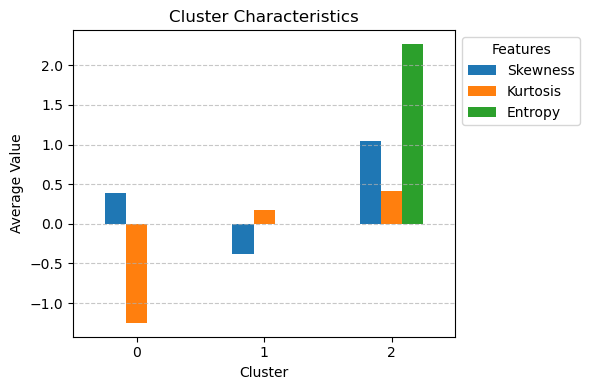

In [2201]:
# Plot a bar chart for each feature
cluster_summary.plot(kind='bar', figsize=(6, 4))
plt.title('Cluster Characteristics')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(title='Features', loc='upper left',bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

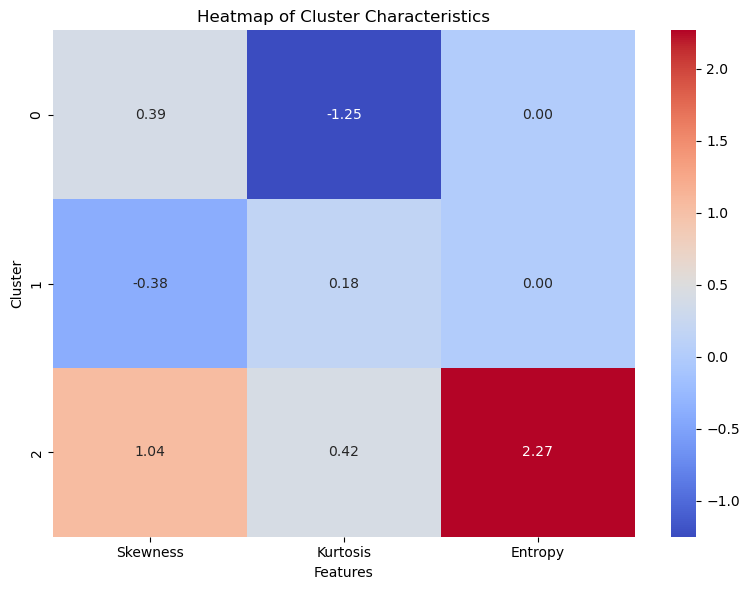

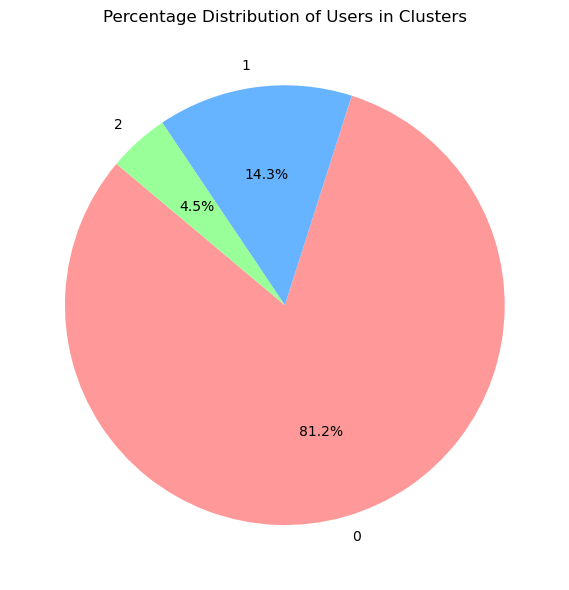

In [2203]:
# Group by cluster and calculate mean for heatmap
cluster_summary = rating_distribution.groupby('Cluster')[['Skewness', 'Kurtosis', 'Entropy']].mean()

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap of Cluster Characteristics")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

# Pie Chart / Percentage Chart
cluster_counts = rating_distribution['Cluster'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Percentage Distribution of Users in Clusters")
plt.tight_layout()
plt.show()

In [2204]:
# Merge basic statistics with rating distribution
user_rating = pd.merge(rating_df, rating_distribution, on='UserID', how='left')
user_rating.head()

,UserID,avg_rating,median_rating,rating_variance,rating_count,std_rating,1,2,3,4,5,Skewness,Kurtosis,Entropy,Cluster
0,1,4.183673,4.0,0.444728,49,0.666879,0.000000,0.000000,0.142857,0.530612,0.326531,0.515865,-1.653807,0.0,0
1,2,3.705882,4.0,1.056830,119,1.028022,0.016807,0.092437,0.336134,0.277311,0.277311,-0.424272,-0.051557,0.0,1
2,3,3.833333,4.0,0.950355,48,0.974861,0.020833,0.083333,0.187500,0.458333,0.250000,0.573963,-1.281747,0.0,0
3,4,4.111111,4.0,1.281046,18,1.131833,0.055556,0.055556,0.055556,0.388889,0.444444,0.437988,-1.967402,0.0,0
4,5,3.160000,3.0,1.296092,175,1.138460,0.097143,0.177143,0.302857,0.314286,0.108571,0.179042,-1.482561,0.0,0


In [2205]:
# Example: Gender prediction
# Assuming 'Gender' is the target variable and available in the dataset
user_rating_cluster = pd.merge(user_rating, users, on='UserID', how='inner')
user_rating_cluster.shape

(6040, 20)

In [2206]:
user_rating_cluster.head(3)

,UserID,avg_rating,median_rating,rating_variance,rating_count,std_rating,1,2,3,4,5,Skewness,Kurtosis,Entropy,Cluster,Gender,Age,Occupation,Zip-code,Age_Group
0,1,4.183673,4.0,0.444728,49,0.666879,0.000000,0.000000,0.142857,0.530612,0.326531,0.515865,-1.653807,0.0,0,F,1,10,48067,Teenager (Under 18)
1,2,3.705882,4.0,1.056830,119,1.028022,0.016807,0.092437,0.336134,0.277311,0.277311,-0.424272,-0.051557,0.0,1,M,56,16,70072,Older Adult (56+)
2,3,3.833333,4.0,0.950355,48,0.974861,0.020833,0.083333,0.187500,0.458333,0.250000,0.573963,-1.281747,0.0,0,M,25,15,55117,Young Adult (18-34)


### Creating Genre Affinity

In [2208]:
# Average rating by genre
genre_avg_rating = {}
for genre in genre_columns.columns:
    genre_avg_rating[genre] = all_data.groupby(genre)['Rating'].mean().rename(f'AvgRating_{genre}')

# Combine genre averages into a DataFrame
genre_avg_rating_df = pd.DataFrame(genre_avg_rating)
genre_avg_rating_df

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,3.607525,3.589812,3.569835,3.584848,3.608867,3.563754,3.571033,3.474326,3.578507,3.564158,3.600221,3.569973,3.569729,3.569867,3.597254,3.576003,3.550573,3.573369
1,3.480250,3.476616,3.672447,3.433178,3.511579,3.690693,3.938582,3.758435,3.457256,4.065661,3.253358,3.661654,3.667276,3.596248,3.448849,3.565061,3.890514,3.597339


In [2209]:
#Calculate Weighted Average Rating and Total Ratings per Genre
# Group ratings by UserID and genre, then calculate the weighted average rating
weighted_avg_ratings = all_data.groupby("UserID")[genre_columns.columns].mean()
weighted_avg_ratings.head(2)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
UserID,,,,,,,,,,,,,,,,,,
1,0.081633,0.102041,0.326531,0.387755,0.224490,0.020408,0.0,0.408163,0.061224,0.000000,0.000000,0.285714,0.00000,0.102041,0.061224,0.040816,0.040816,0.00000
2,0.453782,0.159664,0.000000,0.000000,0.193277,0.092437,0.0,0.605042,0.008403,0.008403,0.016807,0.000000,0.02521,0.193277,0.134454,0.252101,0.117647,0.02521


In [2210]:
# Calculate the total ratings per genre for each user
total_ratings_per_genre = all_data.groupby("UserID")[genre_columns.columns].sum()
total_ratings_per_genre.head(2)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
UserID,,,,,,,,,,,,,,,,,,
1,4,5,16,19,11,1,0,20,3,0,0,14,0,5,3,2,2,0
2,54,19,0,0,23,11,0,72,1,1,2,0,3,23,16,30,14,3


In [2211]:
# Calculate log of total ratings (adding 1 to avoid log(0)) --normalize the data
# Logarithmic scaling is helpful when the raw data has a wide range of values (e.g., some genres have a very high count while others are low)
# For example, the log transformation for User 1's "Action" genre rating (5) becomes approximately 1.609.
# This transformation reduces the skewness and makes it easier to compare users with very different total ratings distributions.

# Purpose of Log Transformation:
# Normalization: Helps to bring large and small values closer together.
# Pattern Detection: Makes it easier to spot trends or compare across users/genres with varied interaction levels.
# Feature Scaling: Useful for machine learning models, where extreme values can negatively impact performance.

log_total_ratings_per_genre = np.log(total_ratings_per_genre + 1)
log_total_ratings_per_genre.head(2)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
UserID,,,,,,,,,,,,,,,,,,
1,1.609438,1.791759,2.833213,2.995732,2.484907,0.693147,0.0,3.044522,1.386294,0.000000,0.000000,2.70805,0.000000,1.791759,1.386294,1.098612,1.098612,0.000000
2,4.007333,2.995732,0.000000,0.000000,3.178054,2.484907,0.0,4.290459,0.693147,0.693147,1.098612,0.00000,1.386294,3.178054,2.833213,3.433987,2.708050,1.386294


In [2212]:
# Calculate Genre Affinity Score
# Multiply Weighted Average Ratings by log(Total Ratings per Genre)
genre_affinity_scores = weighted_avg_ratings * log_total_ratings_per_genre

# Fill NaN values with 0 (e.g., where no ratings exist for a genre)
genre_affinity_scores = genre_affinity_scores.fillna(0)
genre_affinity_scores.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
UserID,,,,,,,,,,,,,,,,,,
1,0.131383,0.182833,0.925131,1.161610,0.557836,0.014146,0.000000,1.242662,0.084875,0.000000,0.000000,0.773729,0.000000,0.182833,0.084875,0.044841,0.044841,0.000000
2,1.818454,0.478310,0.000000,0.000000,0.614246,0.229697,0.000000,2.595908,0.005825,0.005825,0.018464,0.000000,0.034949,0.614246,0.380936,0.865711,0.318594,0.034949
3,1.522817,1.696925,0.045776,0.045776,1.874365,0.000000,0.000000,0.366204,0.045776,0.000000,0.086643,0.014441,0.014441,0.186642,0.243239,0.186642,0.045776,0.243239
4,2.518412,0.648637,0.000000,0.038508,0.000000,0.000000,0.000000,0.648637,0.122068,0.000000,0.231049,0.000000,0.000000,0.038508,1.151293,0.357653,0.231049,0.000000
5,0.514112,0.118419,0.003961,0.036787,1.012039,0.237650,0.066717,2.414437,0.000000,0.023765,0.118419,0.023765,0.100445,0.465442,0.216644,0.742817,0.066717,0.003961


In [2215]:
# Find the highest affinity genre and score for all users
highest_affinity = genre_affinity_scores.idxmax(axis=1)  # Genre with the highest score for each user
highest_scores = genre_affinity_scores.max(axis=1)      # Highest score for each user

# Combine into a DataFrame for better visualization
user_highest_affinities = pd.DataFrame({
    "Highest_Affinity_Genre": highest_affinity,
    "Highest_Affinity_Score": highest_scores
})

user_highest_affinities.head()

,Highest_Affinity_Genre,Highest_Affinity_Score
UserID,,
1,Drama,1.242662
2,Drama,2.595908
3,Comedy,1.874365
4,Action,2.518412
5,Drama,2.414437


In [2216]:
# Create a DataFrame to store results for all users
lower_affinities = []
# some_affinities = []

# Loop through each user in the DataFrame
for user_id in genre_affinity_scores.index:
    # Get affinity scores for the user
    user_affinities = genre_affinity_scores.loc[user_id]

    # Filter for non-zero scores
    non_zero_scores = user_affinities[user_affinities > 0]
    if not non_zero_scores.empty:
        lower_affinity_genre = non_zero_scores.idxmin()  # Genre with the lowest non-zero score
        lower_affinity_score = non_zero_scores.min()     # The score itself
    else:
        lower_affinity_genre, lower_affinity_score = None, None

    # Some affinity (e.g., closest to the median)
    # some_affinity_genre = user_affinities[user_affinities > 0].median()
    # some_affinity_score = user_affinities.median()  # Median score across genres
    
    # Append results
    lower_affinities.append({
        "UserID": user_id,
        "Lower_Affinity_Genre": lower_affinity_genre,
        "Lower_Affinity_Score": lower_affinity_score
        # "Some_Affinity_Genre": some_affinity_genre,
        # "Some_Affinity_Score": some_affinity_score
    })

# Convert the results to a DataFrame
user_lower_affinities = pd.DataFrame(lower_affinities)
user_lower_affinities.head()

,UserID,Lower_Affinity_Genre,Lower_Affinity_Score
0,1,Crime,0.014146
1,2,Fantasy,0.005825
2,3,Musical,0.014441
3,4,Children's,0.038508
4,5,Animation,0.003961


In [2217]:
genre_affinity_scores.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
UserID,,,,,,,,,,,,,,,,,,
1,0.131383,0.182833,0.925131,1.161610,0.557836,0.014146,0.000000,1.242662,0.084875,0.000000,0.000000,0.773729,0.000000,0.182833,0.084875,0.044841,0.044841,0.000000
2,1.818454,0.478310,0.000000,0.000000,0.614246,0.229697,0.000000,2.595908,0.005825,0.005825,0.018464,0.000000,0.034949,0.614246,0.380936,0.865711,0.318594,0.034949
3,1.522817,1.696925,0.045776,0.045776,1.874365,0.000000,0.000000,0.366204,0.045776,0.000000,0.086643,0.014441,0.014441,0.186642,0.243239,0.186642,0.045776,0.243239
4,2.518412,0.648637,0.000000,0.038508,0.000000,0.000000,0.000000,0.648637,0.122068,0.000000,0.231049,0.000000,0.000000,0.038508,1.151293,0.357653,0.231049,0.000000
5,0.514112,0.118419,0.003961,0.036787,1.012039,0.237650,0.066717,2.414437,0.000000,0.023765,0.118419,0.023765,0.100445,0.465442,0.216644,0.742817,0.066717,0.003961


In [2218]:
# Step 1: Calculate genre popularity
genre_popularity = genre_affinity_scores.mean(axis=0)  # Average score for each genre
# Step 2: Sort genres by popularity
genre_popularity_sorted = genre_popularity.sort_values(ascending=False)
genre_popularity_sorted.head()

Drama       1.311282
Comedy      1.278290
Action      0.935648
Thriller    0.632195
Sci-Fi      0.526464
dtype: float64

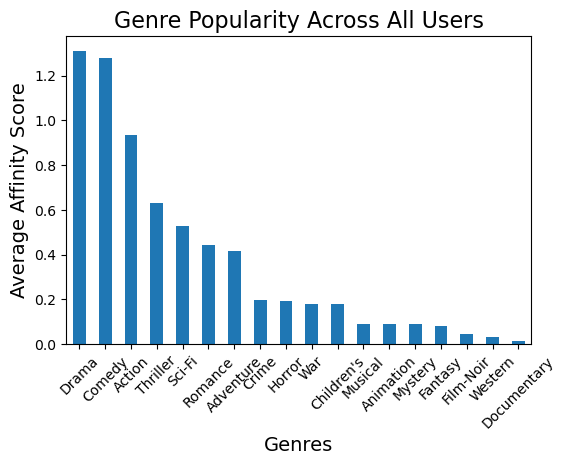

In [2219]:
# Step 3: Visualize genre popularity
plt.figure(figsize=(6, 4))
genre_popularity_sorted.plot(kind='bar')
plt.title("Genre Popularity Across All Users", fontsize=16)
plt.xlabel("Genres", fontsize=14)
plt.ylabel("Average Affinity Score", fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [2220]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code,Age_Group
0,1,F,1,10,48067,Teenager (Under 18)
1,2,M,56,16,70072,Older Adult (56+)
2,3,M,25,15,55117,Young Adult (18-34)
3,4,M,45,7,02460,Middle-Aged Adult (35-55)
4,5,M,25,20,55455,Young Adult (18-34)


In [2221]:
genre_affinity_scores_demographics = pd.merge(genre_affinity_scores, users, on='UserID', how='inner')
genre_affinity_scores_demographics.head()

,UserID,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Gender,Age,Occupation,Zip-code,Age_Group
0,1,0.131383,0.182833,0.925131,1.161610,0.557836,0.014146,0.000000,1.242662,0.084875,0.000000,0.000000,0.773729,0.000000,0.182833,0.084875,0.044841,0.044841,0.000000,F,1,10,48067,Teenager (Under 18)
1,2,1.818454,0.478310,0.000000,0.000000,0.614246,0.229697,0.000000,2.595908,0.005825,0.005825,0.018464,0.000000,0.034949,0.614246,0.380936,0.865711,0.318594,0.034949,M,56,16,70072,Older Adult (56+)
2,3,1.522817,1.696925,0.045776,0.045776,1.874365,0.000000,0.000000,0.366204,0.045776,0.000000,0.086643,0.014441,0.014441,0.186642,0.243239,0.186642,0.045776,0.243239,M,25,15,55117,Young Adult (18-34)
3,4,2.518412,0.648637,0.000000,0.038508,0.000000,0.000000,0.000000,0.648637,0.122068,0.000000,0.231049,0.000000,0.000000,0.038508,1.151293,0.357653,0.231049,0.000000,M,45,7,02460,Middle-Aged Adult (35-55)
4,5,0.514112,0.118419,0.003961,0.036787,1.012039,0.237650,0.066717,2.414437,0.000000,0.023765,0.118419,0.023765,0.100445,0.465442,0.216644,0.742817,0.066717,0.003961,M,25,20,55455,Young Adult (18-34)


In [2222]:
genre_aff_demo =genre_affinity_scores_demographics.copy()

In [2223]:
genre_aff_demo.drop(columns=['UserID','Age','Zip-code', 'Occupation'], inplace=True)

In [2224]:
# Group by Gender and Age Group and calculate mean for each genre
grouped_scores = genre_aff_demo.groupby(['Gender', 'Age_Group']).mean(numeric_only=True)
grouped_scores.head(4)

Action  Adventure  Animation  Children's  \
Gender Age_Group                                                               
F      Middle-Aged Adult (35-55)  0.581036   0.301225   0.088114    0.195949   
       Older Adult (56+)          0.357130   0.193694   0.049148    0.091248   
       Teenager (Under 18)        0.447002   0.396862   0.289134    0.732930   
       Young Adult (18-34)        0.637863   0.325178   0.116808    0.222786   

                                    Comedy     Crime  Documentary     Drama  \
Gender Age_Group                                                              
F      Middle-Aged Adult (35-55)  1.275263  0.156141     0.019482  1.495545   
       Older Adult (56+)          1.026941  0.132927     0.009398  1.779519   
       Teenager (Under 18)        1.599857  0.063707     0.003735  0.862691   
       Young Adult (18-34)        1.528969  0.155467     0.012830  1.400907   

                                   Fantasy  Film-Noir    Horror   Musical  \
Gender Age_Group                                                            
F      Middle-Aged Adult (35-55)  0.066933   0.050558  0.128784  0.132048   
       Older Adult (56+)          0.025332   0.082939  0.060644  0.132208   
       Teenager (Under 18)        0.122085   0.009556  0.230276  0.245721   
       Young Adult (18-34)        0.082532   0.028014  0.152229  0.125364   

                                   Mystery   Romance    Sci-Fi  Thriller  \
Gender Age_Group                                                           
F      Middle-Aged Adult (35-55)  0.105812  0.663804  0.311320  0.526172   
       Older Adult (56+)          0.124203  0.637730  0.190837  0.379228   
       Teenager (Under 18)        0.045003  0.548858  0.291493  0.346695   
       Young Adult (18-34)        0.073542  0.684134  0.322025  0.517664   

                                       War   Western  
Gender Age_Group                                      
F      Middle-Aged Adult (35-55)  0.157700  0.025541  
       Older Adult (56+)          0.177842  0.031238  
       Teenager (Under 18)        0.079596  0.011351  
       Young Adult (18-34)        0.118543  0.012035

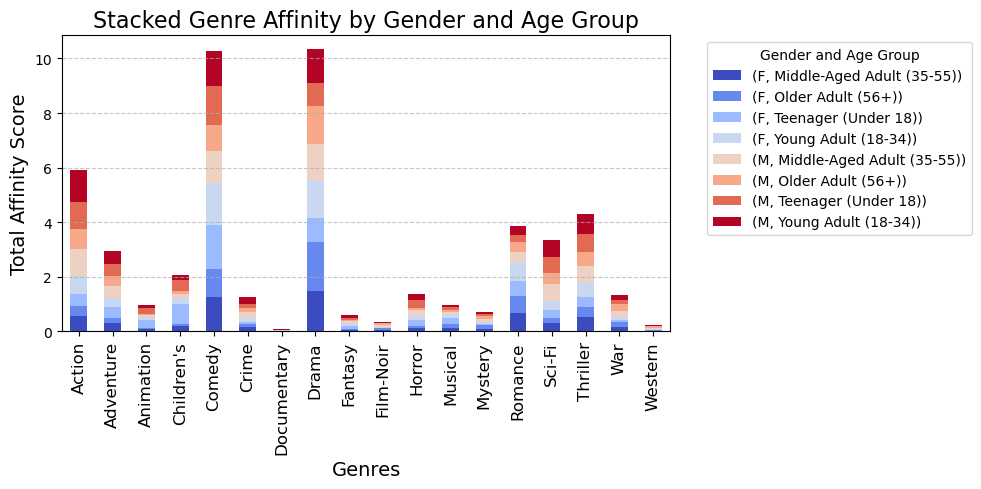

In [2226]:
# Sum genres for stacked representation
stacked_data = grouped_scores.groupby(['Gender', 'Age_Group']).sum()

# Plot stacked bar chart
stacked_data.T.plot(kind='bar', stacked=True, figsize=(10, 5), colormap="coolwarm")
plt.title("Stacked Genre Affinity by Gender and Age Group", fontsize=16)
plt.xlabel("Genres", fontsize=14)
plt.ylabel("Total Affinity Score", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.legend(title="Gender and Age Group", bbox_to_anchor=(1.05, 1),loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [2227]:
# Group by Gender and Age Group and calculate mean for each genre
grouped_scores_gender = genre_aff_demo.groupby(['Gender']).mean(numeric_only=True)
grouped_scores_gender.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Gender,,,,,,,,,,,,,,,,,,
F,0.590018,0.311169,0.109335,0.227650,1.402333,0.150199,0.014830,1.436208,0.074781,0.039328,0.141092,0.133898,0.087971,0.667184,0.308586,0.504949,0.135724,0.018469
M,1.072033,0.459372,0.081997,0.160113,1.229343,0.212982,0.011396,1.261986,0.082954,0.044251,0.212170,0.073937,0.088069,0.355425,0.612438,0.682406,0.197173,0.038173


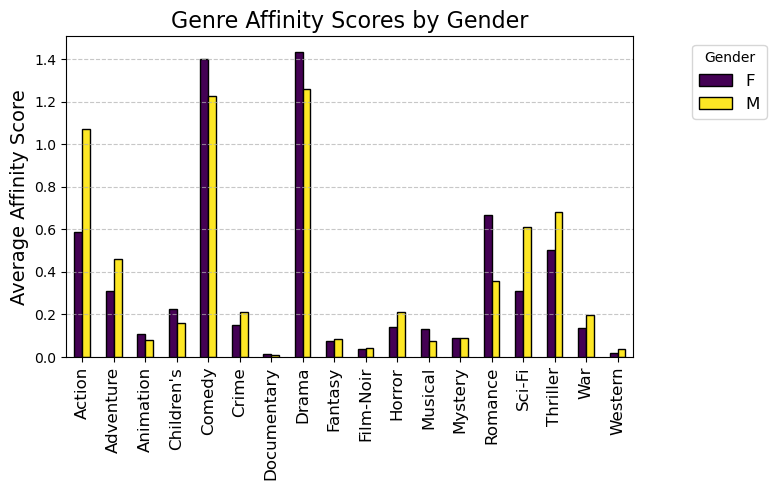

In [2228]:
# Plot grouped bar chart
grouped_scores_gender.T.plot(kind='bar', figsize=(8, 5), colormap='viridis', edgecolor='black')
# Add labels and title
plt.title("Genre Affinity Scores by Gender", fontsize=16)
# plt.xlabel("Genres", fontsize=14)
plt.ylabel("Average Affinity Score", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.legend(title="Gender", fontsize=12, loc='upper right', bbox_to_anchor=(1.25, 1))  # Legend outside
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [2229]:
# Group by Gender and Age Group and calculate mean for each genre
grouped_scores_age = genre_aff_demo.groupby(['Age_Group']).mean(numeric_only=True)
grouped_scores_age.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Age_Group,,,,,,,,,,,,,,,,,,
Middle-Aged Adult (35-55),0.872263,0.398877,0.073678,0.156038,1.197263,0.178904,0.014623,1.378256,0.070124,0.053771,0.178830,0.096152,0.098768,0.462250,0.529421,0.604333,0.202076,0.042098
Older Adult (56+),0.624125,0.315762,0.044965,0.097412,0.992768,0.159374,0.008111,1.505745,0.040292,0.072443,0.087863,0.095723,0.132723,0.437276,0.349820,0.478244,0.227810,0.057858
Teenager (Under 18),0.804197,0.429422,0.241168,0.519131,1.473254,0.119099,0.004893,0.841359,0.105947,0.014656,0.253136,0.154463,0.054466,0.359146,0.467410,0.542526,0.132770,0.013478
Young Adult (18-34),1.026139,0.441676,0.095778,0.181578,1.355388,0.216176,0.011814,1.273917,0.091040,0.033662,0.209456,0.082246,0.077555,0.437228,0.549475,0.676206,0.161744,0.024274


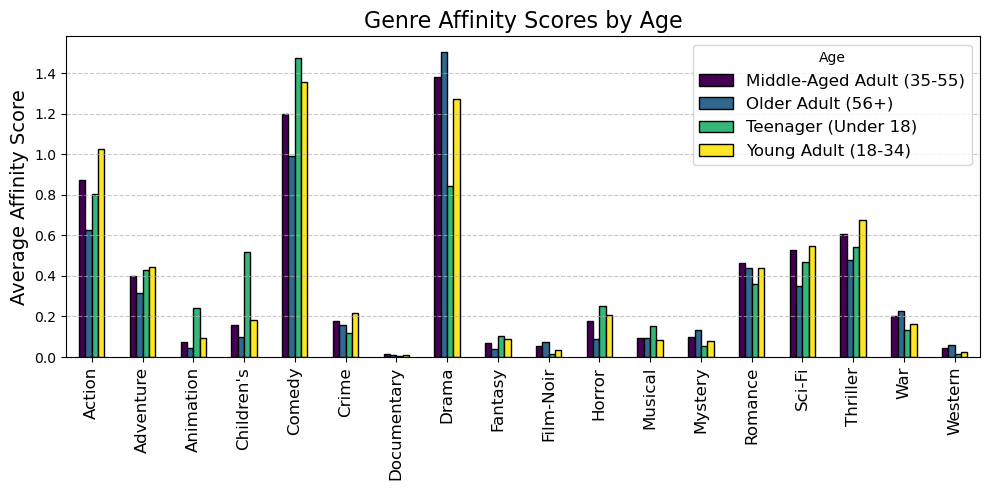

In [2230]:
# Plot grouped bar chart
grouped_scores_age.T.plot(kind='bar', figsize=(10, 5), colormap='viridis', edgecolor='black')
# Add labels and title
plt.title("Genre Affinity Scores by Age", fontsize=16)
# plt.xlabel("Genres", fontsize=14)
plt.ylabel("Average Affinity Score", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.legend(title="Age", fontsize=12, loc='upper right')  # Legend outside
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Demographic Prediction

In [2232]:
# genre_affinity_scores
# user_highest_affinities
# user_lower_affinities
# user_rating_cluster

In [2233]:
user_rating_cluster.head(2)

,UserID,avg_rating,median_rating,rating_variance,rating_count,std_rating,1,2,3,4,5,Skewness,Kurtosis,Entropy,Cluster,Gender,Age,Occupation,Zip-code,Age_Group
0,1,4.183673,4.0,0.444728,49,0.666879,0.000000,0.000000,0.142857,0.530612,0.326531,0.515865,-1.653807,0.0,0,F,1,10,48067,Teenager (Under 18)
1,2,3.705882,4.0,1.056830,119,1.028022,0.016807,0.092437,0.336134,0.277311,0.277311,-0.424272,-0.051557,0.0,1,M,56,16,70072,Older Adult (56+)


In [2234]:
genre_affinity_scores.head(2)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
UserID,,,,,,,,,,,,,,,,,,
1,0.131383,0.182833,0.925131,1.16161,0.557836,0.014146,0.0,1.242662,0.084875,0.000000,0.000000,0.773729,0.000000,0.182833,0.084875,0.044841,0.044841,0.000000
2,1.818454,0.478310,0.000000,0.00000,0.614246,0.229697,0.0,2.595908,0.005825,0.005825,0.018464,0.000000,0.034949,0.614246,0.380936,0.865711,0.318594,0.034949


In [2235]:
user_genre_diversity.head(2)

,UserID,GenreDiversity
0,1,13
1,2,14


In [2236]:
user_features_boxoffice = all_data.groupby('UserID').agg({'BoxOffice': 'mean'}).reset_index()
user_features_boxoffice.head(2)

,UserID,BoxOffice
0,1,1.372832e+08
1,2,9.396518e+07


In [2237]:
selected_columns = ['UserID','Cluster','avg_rating','rating_count','std_rating','Gender','Age_Group']  
# ,'Skewness','Kurtosis','Entropy','median_rating','rating_variance',
rating_distribution_selected = user_rating_cluster[selected_columns]

# .merge(genre_affinity_scores,on="UserID") \
    # .merge(user_lower_affinities,on="UserID") \
    # .merge(rating_distribution_selected,on="UserID")

all_features =pd.merge(rating_distribution_selected,genre_affinity_scores,on = "UserID") \
    .merge(user_genre_diversity,on="UserID")\
    .merge(user_features_boxoffice, on="UserID")
print(all_features.shape)
all_features.head(2)

(6040, 27)


,UserID,Cluster,avg_rating,rating_count,std_rating,Gender,Age_Group,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,GenreDiversity,BoxOffice
0,1,0,4.183673,49,0.666879,F,Teenager (Under 18),0.131383,0.182833,0.925131,1.16161,0.557836,0.014146,0.0,1.242662,0.084875,0.000000,0.000000,0.773729,0.000000,0.182833,0.084875,0.044841,0.044841,0.000000,13,1.372832e+08
1,2,1,3.705882,119,1.028022,M,Older Adult (56+),1.818454,0.478310,0.000000,0.00000,0.614246,0.229697,0.0,2.595908,0.005825,0.005825,0.018464,0.000000,0.034949,0.614246,0.380936,0.865711,0.318594,0.034949,14,9.396518e+07


In [2238]:
# Encode Gender
label_encoder_gender = LabelEncoder()
all_features['Gender'] = label_encoder_gender.fit_transform(all_features['Gender'])

# Encode Age_Group
label_encoder_age = LabelEncoder()
all_features['Age_Group'] = label_encoder_age.fit_transform(all_features['Age_Group'])

In [2239]:
print(all_features["Age_Group"].nunique())
print(all_features["Gender"].nunique())

4
2


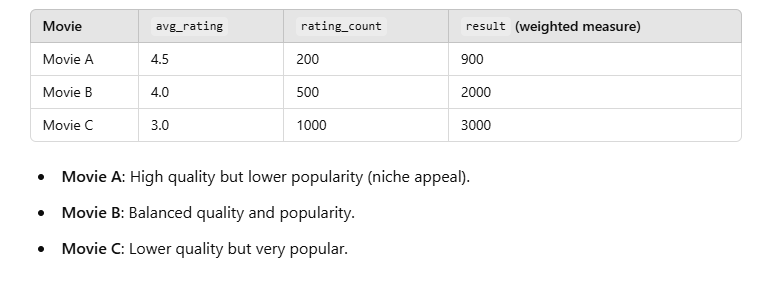

In [2241]:
all_features['weighted_measure'] = all_features['avg_rating'] * all_features['rating_count']
all_features['BoxOffice_Log'] = np.log1p(all_features['BoxOffice'])

In [2242]:
all_features.shape

(6040, 29)

In [2243]:
all_features.head(2)

,UserID,Cluster,avg_rating,rating_count,std_rating,Gender,Age_Group,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,GenreDiversity,BoxOffice,weighted_measure,BoxOffice_Log
0,1,0,4.183673,49,0.666879,0,2,0.131383,0.182833,0.925131,1.16161,0.557836,0.014146,0.0,1.242662,0.084875,0.000000,0.000000,0.773729,0.000000,0.182833,0.084875,0.044841,0.044841,0.000000,13,1.372832e+08,205.0,18.737557
1,2,1,3.705882,119,1.028022,1,1,1.818454,0.478310,0.000000,0.00000,0.614246,0.229697,0.0,2.595908,0.005825,0.005825,0.018464,0.000000,0.034949,0.614246,0.380936,0.865711,0.318594,0.034949,14,9.396518e+07,441.0,18.358435


In [2244]:
all_features.columns

Index(['UserID', 'Cluster', 'avg_rating', 'rating_count', 'std_rating',
       'Gender', 'Age_Group', 'Action', 'Adventure', 'Animation', 'Children's',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'GenreDiversity', 'BoxOffice', 'weighted_measure',
       'BoxOffice_Log'],
      dtype='object')

In [2245]:
# Features and target
# 'Gender','Age_Group',
# features = all_features.drop(['rating_count','weighted_measure','GenreDiversity'], axis=1) 
features = all_features.drop(['Gender','Age_Group','rating_count','GenreDiversity','BoxOffice'], axis=1) 
y_age = all_features['Age_Group']
y_gender = all_features['Gender']

In [2246]:
features.head()

,UserID,Cluster,avg_rating,std_rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,weighted_measure,BoxOffice_Log
0,1,0,4.183673,0.666879,0.131383,0.182833,0.925131,1.161610,0.557836,0.014146,0.000000,1.242662,0.084875,0.000000,0.000000,0.773729,0.000000,0.182833,0.084875,0.044841,0.044841,0.000000,205.0,18.737557
1,2,1,3.705882,1.028022,1.818454,0.478310,0.000000,0.000000,0.614246,0.229697,0.000000,2.595908,0.005825,0.005825,0.018464,0.000000,0.034949,0.614246,0.380936,0.865711,0.318594,0.034949,441.0,18.358435
2,3,0,3.833333,0.974861,1.522817,1.696925,0.045776,0.045776,1.874365,0.000000,0.000000,0.366204,0.045776,0.000000,0.086643,0.014441,0.014441,0.186642,0.243239,0.186642,0.045776,0.243239,184.0,18.650052
3,4,0,4.111111,1.131833,2.518412,0.648637,0.000000,0.038508,0.000000,0.000000,0.000000,0.648637,0.122068,0.000000,0.231049,0.000000,0.000000,0.038508,1.151293,0.357653,0.231049,0.000000,74.0,19.094699
4,5,0,3.160000,1.138460,0.514112,0.118419,0.003961,0.036787,1.012039,0.237650,0.066717,2.414437,0.000000,0.023765,0.118419,0.023765,0.100445,0.465442,0.216644,0.742817,0.066717,0.003961,553.0,17.665312


### Feature Scaling

In [2264]:
# Split data into train and test sets ----20% data for testing, and 80% data for training
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(features, y_gender, test_size=0.2, random_state=42)
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(features, y_age, test_size=0.2, random_state=42)

In [2265]:
y_age.value_counts()

Age_Group
3    3199
0    2239
1     380
2     222
Name: count, dtype: int64

In [2266]:
y_gender.value_counts()

Gender
1    4331
0    1709
Name: count, dtype: int64

In [2267]:
# Apply SMOTE only on the training data
# from imblearn.over_sampling import BorderlineSMOTE, ADASYN

smote = SMOTE(random_state=42)
# smote = ADASYN(random_state=42)
X_train_gender, y_train_gender = smote.fit_resample(X_train_gender, y_train_gender)

smote = SMOTE(random_state=42)
X_train_age, y_train_age = smote.fit_resample(X_train_age, y_train_age)

In [2268]:
# Handling imbalanced data using SMOTE
#https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/
print("For Gender")
print('After OverSampling, the shape of X_train_gender: {}'.format(X_train_gender.shape))
print('After OverSampling, the shape of y_train_gender: {}'.format(X_train_gender.shape))
print(y_train_gender.value_counts())
# print(X_train_gender.value_counts())

For Gender
After OverSampling, the shape of X_train_gender: (6962, 24)
After OverSampling, the shape of y_train_gender: (6962, 24)
Gender
1    3481
0    3481
Name: count, dtype: int64


In [2269]:
# Handling imbalanced data using SMOTE
#https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/
print("For Age")
print('After OverSampling, the shape of X_train_age: {}'.format(X_train_age.shape))
print('After OverSampling, the shape of y_train_age: {}'.format(X_train_age.shape))
print(y_train_age.value_counts())
# print(X_train_gender.value_counts())

For Age
After OverSampling, the shape of X_train_age: (10200, 24)
After OverSampling, the shape of y_train_age: (10200, 24)
Age_Group
1    2550
3    2550
0    2550
2    2550
Name: count, dtype: int64


### Model 1 - Logistic Regression Classifier

In [2271]:
# Object creation, fitting the data & getting predictions 
lr_gender = LogisticRegression() #default sigmoid function to compute probabilities for the two classes
#Train the classifier
lr_gender.fit(X_train_gender,y_train_gender) 
#Predict on the test set
y_pred_lr_gender = lr_gender.predict(X_test_gender) 

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [2272]:
# Evaluate model performance
print("Gender Prediction Accuracy:", accuracy_score(y_test_gender, y_pred_lr_gender))
print("Gender Classification Report:\n", classification_report(y_test_gender, y_pred_lr_gender))

Gender Prediction Accuracy: 0.7442052980132451
Gender Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.74      0.63       358
           1       0.87      0.75      0.80       850

    accuracy                           0.74      1208
   macro avg       0.71      0.74      0.72      1208
weighted avg       0.78      0.74      0.75      1208



**************** LOGISTIC REGRESSION CLASSIFIER MODEL RESULTS -- for Gender **************** 
Accuracy score for testing set:  0.74421
F1 score for testing set:  0.80431
Recall score for testing set:  0.74706
Precision score for testing set:  0.87106


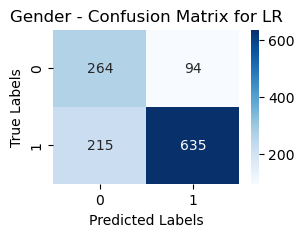

Type 1 Error (False Positives): 94
False Positive Rate (FPR): 0.2626
Type 2 Error (False Negatives): 215


In [2273]:
#Evaluate the classifier 
print("**************** LOGISTIC REGRESSION CLASSIFIER MODEL RESULTS -- for Gender **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_gender,y_pred_lr_gender),5))
print('F1 score for testing set: ',round(f1_score(y_test_gender,y_pred_lr_gender),5))
print('Recall score for testing set: ',round(recall_score(y_test_gender,y_pred_lr_gender),5))
print('Precision score for testing set: ',round(precision_score(y_test_gender,y_pred_lr_gender),5))
cm_lr = confusion_matrix(y_test_gender, y_pred_lr_gender)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))

sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Gender - Confusion Matrix for LR')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel()  # True Negative, False Positive, False Negative, True Positive
type1_error = fp  # False Positives
type2_error = fn  # False Negatives
fpr = fp / (fp + tn)

print(f"Type 1 Error (False Positives): {type1_error}")
print(f"False Positive Rate (FPR): {fpr:.4f}") #The model incorrectly predicts females as males ~37.7% of the time.
print(f"Type 2 Error (False Negatives): {type2_error}")

In [2274]:
lr_age = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr_age.fit(X_train_age,y_train_age) 
y_pred_lr_age = lr_age.predict(X_test_age) 

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [2275]:
# Evaluate model performance
print("Age Prediction Accuracy:", accuracy_score(y_test_age, y_pred_lr_age))
print("Age Classification Report:\n", classification_report(y_test_age, y_pred_lr_age))

Age Prediction Accuracy: 0.3394039735099338
Age Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.17      0.24       418
           1       0.12      0.60      0.21        84
           2       0.12      0.47      0.19        57
           3       0.64      0.41      0.50       649

    accuracy                           0.34      1208
   macro avg       0.33      0.41      0.28      1208
weighted avg       0.51      0.34      0.37      1208



**************** LOGISTIC REGRESSION CLASSIFIER MODEL RESULTS -- for Age **************** 
Accuracy score for testing set:  0.3394
F1 score for testing set: 0.37332
Recall score for testing set: 0.3394
Precision score for testing set: 0.50552


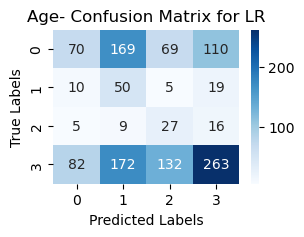


Class 0: Type 1 Error = 97, Type 2 Error = 348
Class 1: Type 1 Error = 350, Type 2 Error = 34
Class 2: Type 1 Error = 206, Type 2 Error = 30
Class 3: Type 1 Error = 145, Type 2 Error = 386


In [2392]:
#Evaluate the classifier 
print("**************** LOGISTIC REGRESSION CLASSIFIER MODEL RESULTS -- for Age **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_age,y_pred_lr_age),5))

print("F1 score for testing set:", round(f1_score(y_test_age, y_pred_lr_age, average='weighted'), 5))
print("Recall score for testing set:", round(recall_score(y_test_age, y_pred_lr_age, average='weighted'), 5))
print("Precision score for testing set:", round(precision_score(y_test_age, y_pred_lr_age, average='weighted'), 5))

cm_lr = confusion_matrix(y_test_age, y_pred_lr_age)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Age- Confusion Matrix for LR')

ax.xaxis.set_ticklabels(['0', '1', '2', '3'])  # Replace with your actual class labels
ax.yaxis.set_ticklabels(['0', '1', '2', '3'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel() if cm_lr.size == 4 else (None, None, None, None)  # Works for binary case only
if tn is not None and fp is not None:
    type1_error = fp  # False Positives
    type2_error = fn  # False Negatives

    print(f"Type 1 Error (False Positives): {type1_error}")
    print(f"Type 2 Error (False Negatives): {type2_error}")
else:
    print("")#"Type 1 and Type 2 error extraction is only applicable for binary classification.")

for i, class_label in enumerate(['0', '1', '2', '3']):  # Replace with actual class names
    type1_error = cm_lr[:, i].sum() - cm_lr[i, i]  # False Positives for this class
    type2_error = cm_lr[i, :].sum() - cm_lr[i, i]  # False Negatives for this class
    print(f"Class {class_label}: Type 1 Error = {type1_error}, Type 2 Error = {type2_error}")

### Model 2 - Random Forest Classifier

In [2278]:
# Initialize models
# gender_model = RandomForestClassifier(random_state=42)
rf_gender = RandomForestClassifier(random_state=42) 
rf_gender.fit(X_train_gender,y_train_gender) 
y_pred_rf_gender = rf_gender.predict(X_test_gender) 

In [2279]:
# Evaluate model performance
print("Gender Prediction Accuracy:", accuracy_score(y_test_gender, y_pred_rf_gender))
print("Gender Classification Report:\n", classification_report(y_test_gender, y_pred_rf_gender))

Gender Prediction Accuracy: 0.7591059602649006
Gender Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.65      0.62       358
           1       0.85      0.80      0.82       850

    accuracy                           0.76      1208
   macro avg       0.71      0.73      0.72      1208
weighted avg       0.77      0.76      0.76      1208



**************** Random Forest CLASSIFIER MODEL RESULTS -- for Gender **************** 
Accuracy score for testing set:  0.75911
F1 score for male for testing set:  0.82459
Recall score for male for testing set:  0.80471
Precision score for male for testing set:  0.84549


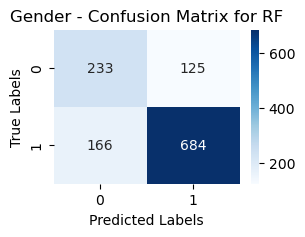

Type 1 Error (False Positives): 125
False Positive Rate (FPR): 0.3492
Type 2 Error (False Negatives): 166


In [2280]:
#Evaluate the classifier 
print("**************** Random Forest CLASSIFIER MODEL RESULTS -- for Gender **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_gender,y_pred_rf_gender),5))
print('F1 score for male for testing set: ',round(f1_score(y_test_gender,y_pred_rf_gender),5)) #Balances precision and recall for "Male" predictions.
print('Recall score for male for testing set: ',round(recall_score(y_test_gender,y_pred_rf_gender),5)) #The model identifies ~81.4% of all actual "Male" cases.
print('Precision score for male for testing set: ',round(precision_score(y_test_gender,y_pred_rf_gender),5)) #When the model predicts "Male," it's correct ~83.7% of the time.

cm_lr = confusion_matrix(y_test_gender, y_pred_rf_gender)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Gender - Confusion Matrix for RF')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel()  # True Negative, False Positive, False Negative, True Positive
type1_error = fp  # False Positives
type2_error = fn  # False Negatives
fpr = fp / (fp + tn)


print(f"Type 1 Error (False Positives): {type1_error}")
print(f"False Positive Rate (FPR): {fpr:.4f}") #The model incorrectly predicts females as males ~37.7% of the time.
print(f"Type 2 Error (False Negatives): {type2_error}")

In [2283]:
# age_model = RandomForestClassifier(random_state=42)
rf_age = RandomForestClassifier(random_state=42)
rf_age.fit(X_train_age,y_train_age) 
y_pred_rf_age = rf_age.predict(X_test_age) 

In [2284]:
# Evaluate model performance
print("Age Prediction Accuracy:", accuracy_score(y_test_age, y_pred_rf_age))
print("Age Classification Report:\n", classification_report(y_test_age, y_pred_rf_age))

Age Prediction Accuracy: 0.5554635761589404
Age Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.45      0.47       418
           1       0.22      0.23      0.22        84
           2       0.21      0.26      0.23        57
           3       0.68      0.69      0.69       649

    accuracy                           0.56      1208
   macro avg       0.40      0.41      0.40      1208
weighted avg       0.56      0.56      0.56      1208



**************** Random Forest CLASSIFIER MODEL RESULTS -- for Age **************** 
Accuracy score for testing set:  0.55546
F1 score for testing set: 0.55628
Recall score for testing set: 0.55546
Precision score for testing set: 0.55771


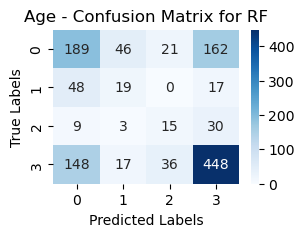


Class 0: Type 1 Error = 205, Type 2 Error = 229
Class 1: Type 1 Error = 66, Type 2 Error = 65
Class 2: Type 1 Error = 57, Type 2 Error = 42
Class 3: Type 1 Error = 209, Type 2 Error = 201


In [2390]:
#Evaluate the classifier 
print("**************** Random Forest CLASSIFIER MODEL RESULTS -- for Age **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_age,y_pred_rf_age),5))

print("F1 score for testing set:", round(f1_score(y_test_age, y_pred_rf_age, average='weighted'), 5))
print("Recall score for testing set:", round(recall_score(y_test_age, y_pred_rf_age, average='weighted'), 5))
print("Precision score for testing set:", round(precision_score(y_test_age, y_pred_rf_age, average='weighted'), 5))

cm_lr = confusion_matrix(y_test_age, y_pred_rf_age)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Age - Confusion Matrix for RF')

ax.xaxis.set_ticklabels(['0', '1', '2', '3'])  # Replace with your actual class labels
ax.yaxis.set_ticklabels(['0', '1', '2', '3'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel() if cm_lr.size == 4 else (None, None, None, None)  # Works for binary case only
if tn is not None and fp is not None:
    type1_error = fp  # False Positives
    type2_error = fn  # False Negatives

    print(f"Type 1 Error (False Positives): {type1_error}")
    print(f"Type 2 Error (False Negatives): {type2_error}")
else:
    print("")#"Type 1 and Type 2 error extraction is only applicable for binary classification.")


for i, class_label in enumerate(['0', '1', '2', '3']):  # Replace with actual class names
    type1_error = cm_lr[:, i].sum() - cm_lr[i, i]  # False Positives for this class
    type2_error = cm_lr[i, :].sum() - cm_lr[i, i]  # False Negatives for this class
    print(f"Class {class_label}: Type 1 Error = {type1_error}, Type 2 Error = {type2_error}")

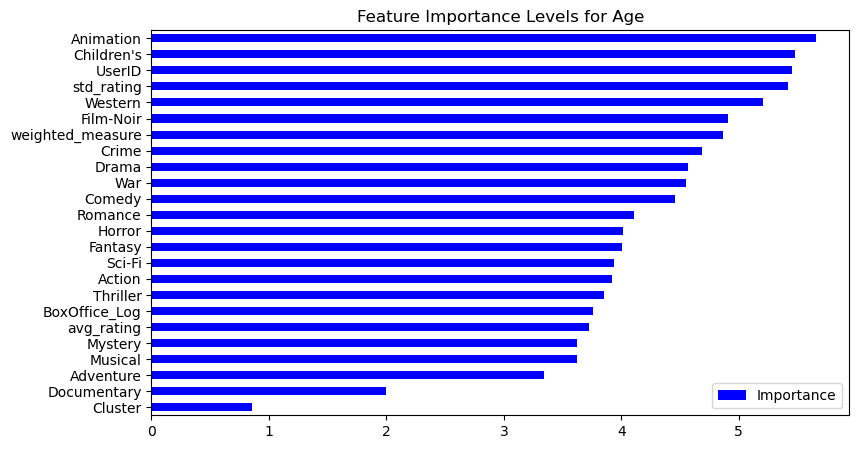

In [2286]:
Importance =pd.DataFrame({"Importance": rf_age.feature_importances_*100},index = X_train_age.columns)
Importance.sort_values(by = "Importance", axis = 0, ascending = True).tail(50).plot(kind ="barh", color = "b",figsize=(9, 5))
plt.title("Feature Importance Levels for Age");
# plt.savefig('Feature_Importance_RF.png', bbox_inches='tight')
plt.show()

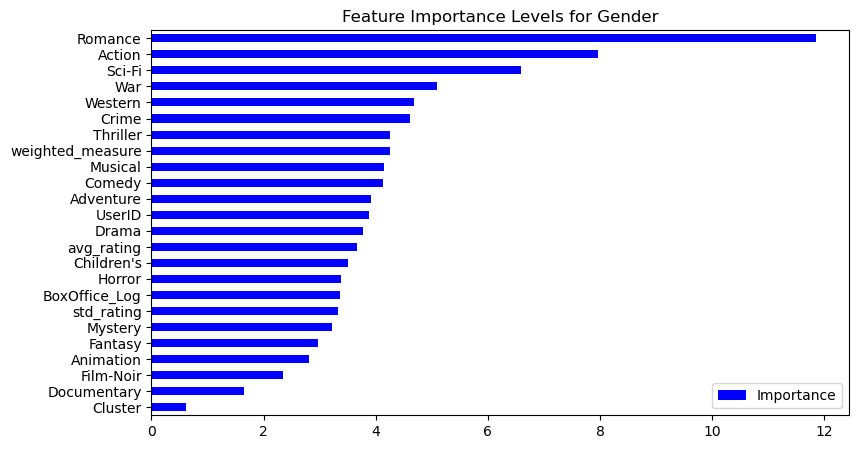

In [2287]:
Importance =pd.DataFrame({"Importance": rf_gender.feature_importances_*100},index = X_train_gender.columns)
Importance.sort_values(by = "Importance", axis = 0, ascending = True).tail(50).plot(kind ="barh", color = "b",figsize=(9, 5))
plt.title("Feature Importance Levels for Gender");
# plt.savefig('Feature_Importance_RF.png', bbox_inches='tight')
plt.show()

### Model 3 - XGBoost

In [2289]:
# Initialize XGBoost Classifier for binary classification
xgb_gender = xgb.XGBClassifier(
    objective='binary:logistic',  # Objective for binary classification
    eval_metric='logloss',       # Log loss metric
    n_estimators=100,            # Number of trees
    learning_rate=0.1,           # Learning rate
    max_depth=6,                 # Maximum depth of each tree
    random_state=42
)
xgb_gender.fit(X_train_gender, y_train_gender)
y_pred_xgb_gender = xgb_gender.predict(X_test_gender)

In [2290]:
# Evaluate model performance
print("Gender Prediction Accuracy:", accuracy_score(y_test_gender, y_pred_xgb_gender))
print("Gender Classification Report:\n", classification_report(y_test_gender, y_pred_xgb_gender))

Gender Prediction Accuracy: 0.7549668874172185
Gender Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.63      0.61       358
           1       0.84      0.81      0.82       850

    accuracy                           0.75      1208
   macro avg       0.71      0.72      0.71      1208
weighted avg       0.76      0.75      0.76      1208



**************** XGBoost MODEL RESULTS -- for Gender **************** 
Accuracy score for testing set:  0.75497
F1 score for testing set:  0.82233
Recall score for testing set:  0.80588
Precision score for testing set:  0.83946


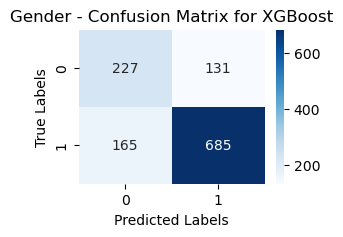

Type 1 Error (False Positives): 131
False Positive Rate (FPR): 0.3659
Type 2 Error (False Negatives): 165


In [2291]:
#Evaluate the classifier 
print("**************** XGBoost MODEL RESULTS -- for Gender **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_gender,y_pred_xgb_gender),5))
print('F1 score for testing set: ',round(f1_score(y_test_gender,y_pred_xgb_gender),5))
print('Recall score for testing set: ',round(recall_score(y_test_gender,y_pred_xgb_gender),5))
print('Precision score for testing set: ',round(precision_score(y_test_gender,y_pred_xgb_gender),5))
cm_lr = confusion_matrix(y_test_gender, y_pred_xgb_gender)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Gender - Confusion Matrix for XGBoost')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel()  # True Negative, False Positive, False Negative, True Positive
type1_error = fp  # False Positives
type2_error = fn  # False Negatives
fpr = fp / (fp + tn)

print(f"Type 1 Error (False Positives): {type1_error}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"Type 2 Error (False Negatives): {type2_error}")

In [2292]:
xgb_age = xgb.XGBClassifier(
    objective='multi:softmax',  # Use 'multi:softmax' for multi-class or 'binary:logistic' for binary classification
    num_class=len(y_age.unique()) if len(y_age.unique()) > 2 else None,  # Needed for multi-class
    eval_metric='mlogloss',  # Log loss for multi-class classification
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Learning rate
    max_depth=6,             # Max depth of each tree
    random_state=42
)
xgb_age.fit(X_train_age, y_train_age)
y_pred_xgb_age = xgb_age.predict(X_test_age)

In [2293]:
# Evaluate model performance
print("Age Prediction Accuracy:", accuracy_score(y_test_age, y_pred_xgb_age))
print("Age Classification Report:\n", classification_report(y_test_age, y_pred_xgb_age))

Age Prediction Accuracy: 0.5372516556291391
Age Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.45      0.47       418
           1       0.18      0.23      0.20        84
           2       0.22      0.35      0.27        57
           3       0.68      0.65      0.66       649

    accuracy                           0.54      1208
   macro avg       0.39      0.42      0.40      1208
weighted avg       0.55      0.54      0.54      1208



**************** XGBoost MODEL RESULTS -- for Age **************** 
Accuracy score for testing set:  0.53725
F1 score for testing set: 0.54469
Recall score for testing set: 0.53725
Precision score for testing set: 0.55477


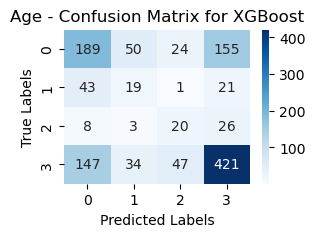

Type 1 and Type 2 error extraction is only applicable for binary classification.
Class 0: Type 1 Error = 198, Type 2 Error = 229
Class 1: Type 1 Error = 87, Type 2 Error = 65
Class 2: Type 1 Error = 72, Type 2 Error = 37
Class 3: Type 1 Error = 202, Type 2 Error = 228


In [2294]:
#Evaluate the classifier 
print("**************** XGBoost MODEL RESULTS -- for Age **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_age,y_pred_xgb_age),5))

print("F1 score for testing set:", round(f1_score(y_test_age, y_pred_xgb_age, average='weighted'), 5))
print("Recall score for testing set:", round(recall_score(y_test_age, y_pred_xgb_age, average='weighted'), 5))
print("Precision score for testing set:", round(precision_score(y_test_age, y_pred_xgb_age, average='weighted'), 5))

cm_lr = confusion_matrix(y_test_age, y_pred_xgb_age)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Age - Confusion Matrix for XGBoost')

ax.xaxis.set_ticklabels(['0', '1', '2', '3'])  # Replace with your actual class labels
ax.yaxis.set_ticklabels(['0', '1', '2', '3'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel() if cm_lr.size == 4 else (None, None, None, None)  # Works for binary case only
if tn is not None and fp is not None:
    type1_error = fp  # False Positives
    type2_error = fn  # False Negatives

    print(f"Type 1 Error (False Positives): {type1_error}")
    print(f"Type 2 Error (False Negatives): {type2_error}")
else:
    print("Type 1 and Type 2 error extraction is only applicable for binary classification.")

for i, class_label in enumerate(['0', '1', '2', '3']):  # Replace with actual class names
    type1_error = cm_lr[:, i].sum() - cm_lr[i, i]  # False Positives for this class
    type2_error = cm_lr[i, :].sum() - cm_lr[i, i]  # False Negatives for this class
    print(f"Class {class_label}: Type 1 Error = {type1_error}, Type 2 Error = {type2_error}")

### Model 4- GradientBoostingClassifier

In [2296]:
# Initialize the Gradient Boosting Classifier
gb_gender = GradientBoostingClassifier(
    n_estimators=100,       # Number of boosting stages
    learning_rate=0.1,      # Learning rate (step size)
    max_depth=3,            # Maximum depth of each tree
    random_state=42
)
gb_gender.fit(X_train_gender,y_train_gender) 
y_pred_gb_gender = gb_gender.predict(X_test_gender) 

In [2297]:
# Evaluate model performance
print("Gender Prediction Accuracy:", accuracy_score(y_test_gender, y_pred_gb_gender))
print("Gender Classification Report:\n", classification_report(y_test_gender, y_pred_gb_gender))

Gender Prediction Accuracy: 0.7615894039735099
Gender Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.72      0.64       358
           1       0.87      0.78      0.82       850

    accuracy                           0.76      1208
   macro avg       0.72      0.75      0.73      1208
weighted avg       0.78      0.76      0.77      1208



**************** Gradient Boosting CLASSIFIER MODEL RESULTS -- for Gender **************** 
Accuracy score for testing set:  0.76159
F1 score for testing set:  0.82178
Recall score for testing set:  0.78118
Precision score for testing set:  0.86684


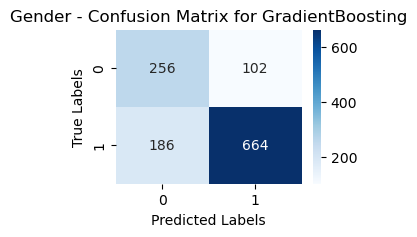

Type 1 Error (False Positives): 102
False Positive Rate (FPR): 0.2849
Type 2 Error (False Negatives): 186


In [2298]:
#Evaluate the classifier 
print("**************** Gradient Boosting CLASSIFIER MODEL RESULTS -- for Gender **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_gender,y_pred_gb_gender),5))
print('F1 score for testing set: ',round(f1_score(y_test_gender,y_pred_gb_gender),5))
print('Recall score for testing set: ',round(recall_score(y_test_gender,y_pred_gb_gender),5))
print('Precision score for testing set: ',round(precision_score(y_test_gender,y_pred_gb_gender),5))
cm_lr = confusion_matrix(y_test_gender, y_pred_gb_gender)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Gender - Confusion Matrix for GradientBoosting')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel()  # True Negative, False Positive, False Negative, True Positive
type1_error = fp  # False Positives
type2_error = fn  # False Negatives
fpr = fp / (fp + tn)

print(f"Type 1 Error (False Positives): {type1_error}")
print(f"False Positive Rate (FPR): {fpr:.4f}") #The model incorrectly predicts females as males ~37.7% of the time.
print(f"Type 2 Error (False Negatives): {type2_error}")

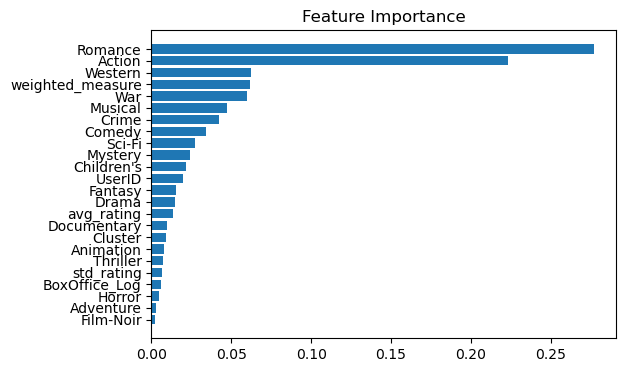

In [2299]:
# Feature importance plot
feature_importance = gb_gender.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(6, 4))
plt.barh(range(len(feature_importance)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(feature_importance)), [features.columns[i] for i in sorted_idx])
plt.title('Feature Importance')
plt.show()

In [2300]:
# Initialize the Gradient Boosting Classifier
gb_age = GradientBoostingClassifier(
    n_estimators=100,       # Number of boosting stages
    learning_rate=0.1,      # Learning rate (step size)
    max_depth=3,            # Maximum depth of each tree
    random_state=42
)
gb_age.fit(X_train_age,y_train_age) 
y_pred_gb_age = gb_age.predict(X_test_age) 

In [2301]:
# Evaluate model performance
print("Age Prediction Accuracy:", accuracy_score(y_test_age, y_pred_gb_age))
print("Age Classification Report:\n", classification_report(y_test_age, y_pred_gb_age))

Age Prediction Accuracy: 0.4991721854304636
Age Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.39      0.42       418
           1       0.20      0.39      0.26        84
           2       0.19      0.40      0.26        57
           3       0.68      0.59      0.63       649

    accuracy                           0.50      1208
   macro avg       0.38      0.44      0.39      1208
weighted avg       0.55      0.50      0.52      1208



**************** Gradient Boosting CLASSIFIER MODEL RESULTS -- for Age **************** 
Accuracy score for testing set:  0.49917
F1 score for testing set: 0.51589
Recall score for testing set: 0.49917
Precision score for testing set: 0.54588


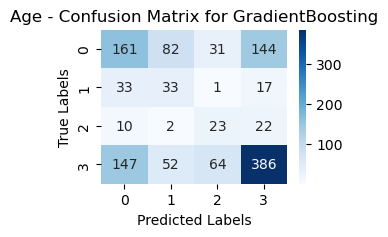

Type 1 and Type 2 error extraction is only applicable for binary classification.
Class 0: Type 1 Error = 190, Type 2 Error = 257
Class 1: Type 1 Error = 136, Type 2 Error = 51
Class 2: Type 1 Error = 96, Type 2 Error = 34
Class 3: Type 1 Error = 183, Type 2 Error = 263


In [2302]:
#Evaluate the classifier 
print("**************** Gradient Boosting CLASSIFIER MODEL RESULTS -- for Age **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_age,y_pred_gb_age),5))

print("F1 score for testing set:", round(f1_score(y_test_age, y_pred_gb_age, average='weighted'), 5))
print("Recall score for testing set:", round(recall_score(y_test_age, y_pred_gb_age, average='weighted'), 5))
print("Precision score for testing set:", round(precision_score(y_test_age, y_pred_gb_age, average='weighted'), 5))

cm_lr = confusion_matrix(y_test_age, y_pred_gb_age)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Age - Confusion Matrix for GradientBoosting')

ax.xaxis.set_ticklabels(['0', '1', '2', '3'])  # Replace with your actual class labels
ax.yaxis.set_ticklabels(['0', '1', '2', '3'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel() if cm_lr.size == 4 else (None, None, None, None)  # Works for binary case only
if tn is not None and fp is not None:
    type1_error = fp  # False Positives
    type2_error = fn  # False Negatives

    print(f"Type 1 Error (False Positives): {type1_error}")
    print(f"Type 2 Error (False Negatives): {type2_error}")
else:
    print("Type 1 and Type 2 error extraction is only applicable for binary classification.")

for i, class_label in enumerate(['0', '1', '2', '3']):  # Replace with actual class names
    type1_error = cm_lr[:, i].sum() - cm_lr[i, i]  # False Positives for this class
    type2_error = cm_lr[i, :].sum() - cm_lr[i, i]  # False Negatives for this class
    print(f"Class {class_label}: Type 1 Error = {type1_error}, Type 2 Error = {type2_error}")

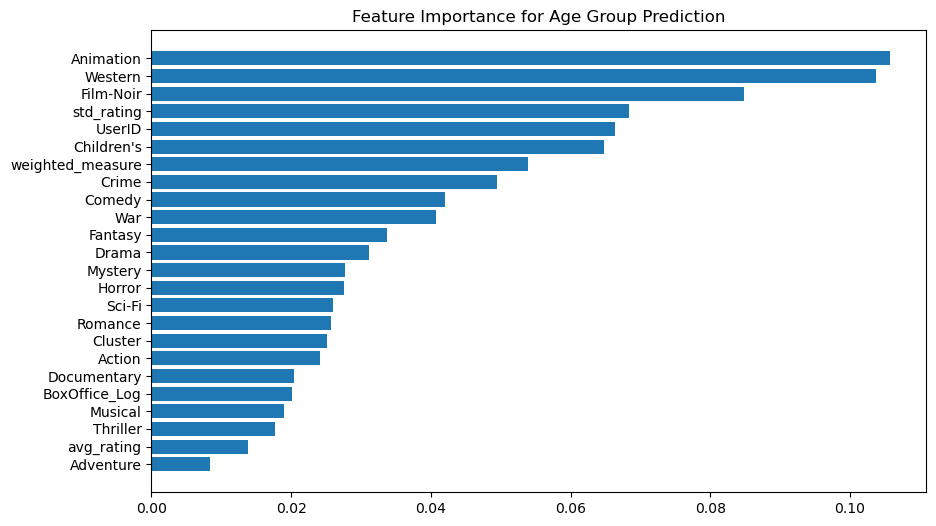

In [2303]:
# Feature importance plot
feature_importance = gb_age.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(feature_importance)), [features.columns[i] for i in sorted_idx])
plt.title('Feature Importance for Age Group Prediction')
plt.show()

In [2304]:
# ## Hyperparameter Tuning
# from sklearn.model_selection import GridSearchCV

# # Define parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.6, 0.8, 1.0]
# }

# # Grid search
# grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train_gender, y_train_gender)

# # Print best parameters
# print("Best Parameters:", grid_search.best_params_)

# # Train the model with best parameters
# best_model = grid_search.best_estimator_

### Model 5 - MLP Classifier

In [2306]:
# # Standardize features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(features)

# # Split data into train and test sets
# X_train_gender_s, X_test_gender_s, y_train_gender_s, y_test_gender_s = train_test_split(X_scaled, y_gender, test_size=0.2, random_state=42)
# X_train_age_s, X_test_age_s, y_train_age_s, y_test_age_s = train_test_split(X_scaled, y_age, test_size=0.2, random_state=42)

In [2307]:
# Initialize MLPClassifier
# mlp_binary = MLPClassifier(hidden_layer_sizes=(20,), activation='relu', solver='adam', random_state=42, alpha= 0.05)

mlp_gender = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),  # Increased complexity
    activation='relu',            # Activation function for hidden layers
    solver='adam',                # Optimizer
    # max_iter=300,                 # Maximum number of iterations
    tol=1e-5,
    learning_rate_init=0.001,  # Slightly higher or lower initial learning rate
    random_state=42,              # Reproducibility
    alpha= 0.05,
    verbose=True                  # Show training progress
)

# Fit the model
mlp_gender.fit(X_train_gender, y_train_gender)
# Predict on the test set
y_pred_mlp_gender = mlp_gender.predict(X_test_gender)

Iteration 1, loss = 11.76604251
Iteration 2, loss = 4.65206533
Iteration 3, loss = 3.13000825
Iteration 4, loss = 3.76386155
Iteration 5, loss = 3.48611169
Iteration 6, loss = 1.18878931
Iteration 7, loss = 1.83983950
Iteration 8, loss = 1.85840391
Iteration 9, loss = 2.51141233
Iteration 10, loss = 2.85764880
Iteration 11, loss = 2.53896586
Iteration 12, loss = 2.61565861
Iteration 13, loss = 2.25174482
Iteration 14, loss = 2.36142092
Iteration 15, loss = 0.93287847
Iteration 16, loss = 0.97770920
Iteration 17, loss = 1.47524234
Iteration 18, loss = 0.80839707
Iteration 19, loss = 1.05813951
Iteration 20, loss = 0.90134839
Iteration 21, loss = 1.45625970
Iteration 22, loss = 1.81275184
Iteration 23, loss = 1.20212848
Iteration 24, loss = 1.20809541
Iteration 25, loss = 0.91794981
Iteration 26, loss = 0.73783510
Iteration 27, loss = 0.92313848
Iteration 28, loss = 0.89279636
Iteration 29, loss = 0.71505952
Iteration 30, loss = 0.65708768
Iteration 31, loss = 1.20310122
Iteration 32, lo

In [2308]:
# Evaluate model performance
print("Gender Prediction Accuracy:", accuracy_score(y_test_gender, y_pred_mlp_gender))
print("Gender Classification Report:\n", classification_report(y_test_gender, y_pred_mlp_gender))

Gender Prediction Accuracy: 0.6705298013245033
Gender Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.32      0.36       358
           1       0.74      0.82      0.78       850

    accuracy                           0.67      1208
   macro avg       0.58      0.57      0.57      1208
weighted avg       0.65      0.67      0.66      1208



**************** MLP CLASSIFIER MODEL RESULTS -- for Gender **************** 
Accuracy score for testing set:  0.67053
F1 score for testing set:  0.77765
Recall score for testing set:  0.81882
Precision score for testing set:  0.74043


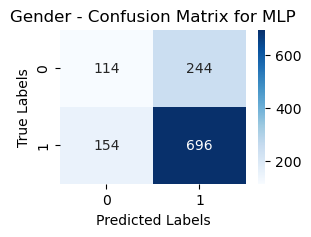

Type 1 Error (False Positives): 244
False Positive Rate (FPR): 0.6816
Type 2 Error (False Negatives): 154


In [2309]:
#Evaluate the classifier 
print("**************** MLP CLASSIFIER MODEL RESULTS -- for Gender **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_gender,y_pred_mlp_gender),5))
print('F1 score for testing set: ',round(f1_score(y_test_gender,y_pred_mlp_gender),5))
print('Recall score for testing set: ',round(recall_score(y_test_gender,y_pred_mlp_gender),5))
print('Precision score for testing set: ',round(precision_score(y_test_gender,y_pred_mlp_gender),5))
cm_lr = confusion_matrix(y_test_gender, y_pred_mlp_gender)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Gender - Confusion Matrix for MLP')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel()  # True Negative, False Positive, False Negative, True Positive
type1_error = fp  # False Positives
type2_error = fn  # False Negatives
fpr = fp / (fp + tn)

print(f"Type 1 Error (False Positives): {type1_error}")
print(f"False Positive Rate (FPR): {fpr:.4f}") #The model incorrectly predicts females as males ~37.7% of the time.
print(f"Type 2 Error (False Negatives): {type2_error}")

In [2310]:
# Ensure y contains class labels (e.g., [0, 1, 2, 3] for age groups)
mlp_age = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),  # Increased complexity
    activation='relu',            # Activation function for hidden layers
    solver='adam',                # Optimizer
    # max_iter=300,                 # Maximum number of iterations
    tol=1e-5,
    learning_rate_init=0.001,  # Slightly higher or lower initial learning rate
    random_state=42,              # Reproducibility
    alpha= 0.05,
    verbose=True   
)
mlp_age.fit(X_train_age, y_train_age)
y_pred_mlp_age = mlp_age.predict(X_test_age)

Iteration 1, loss = 14.62701893
Iteration 2, loss = 9.83580021
Iteration 3, loss = 11.78954938
Iteration 4, loss = 8.34872243
Iteration 5, loss = 6.96450738
Iteration 6, loss = 7.39048418
Iteration 7, loss = 5.00844441
Iteration 8, loss = 3.21307542
Iteration 9, loss = 3.58837849
Iteration 10, loss = 3.34805210
Iteration 11, loss = 4.44146583
Iteration 12, loss = 2.44698432
Iteration 13, loss = 3.24883173
Iteration 14, loss = 3.95342310
Iteration 15, loss = 4.60577364
Iteration 16, loss = 2.89048168
Iteration 17, loss = 1.87051894
Iteration 18, loss = 2.04505259
Iteration 19, loss = 2.25225759
Iteration 20, loss = 2.11141897
Iteration 21, loss = 2.03409373
Iteration 22, loss = 1.95046587
Iteration 23, loss = 1.90814768
Iteration 24, loss = 2.09750904
Iteration 25, loss = 3.00500881
Iteration 26, loss = 2.04177556
Iteration 27, loss = 1.36862394
Iteration 28, loss = 1.56773680
Iteration 29, loss = 1.38909492
Iteration 30, loss = 1.65220849
Iteration 31, loss = 1.56031167
Iteration 32, l

In [2311]:
# Evaluate model performance
print("Age Prediction Accuracy:", accuracy_score(y_test_age, y_pred_mlp_age))
print("Age Classification Report:\n", classification_report(y_test_age, y_pred_mlp_age))

Age Prediction Accuracy: 0.2433774834437086
Age Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.26      0.30       418
           1       0.09      0.70      0.16        84
           2       0.19      0.26      0.22        57
           3       0.65      0.17      0.27       649

    accuracy                           0.24      1208
   macro avg       0.32      0.35      0.24      1208
weighted avg       0.48      0.24      0.27      1208



**************** MLP CLASSIFIER MODEL RESULTS -- for Age **************** 
Accuracy score for testing set:  0.24338
F1 score for testing set: 0.27132
Recall score for testing set: 0.24338
Precision score for testing set: 0.48348


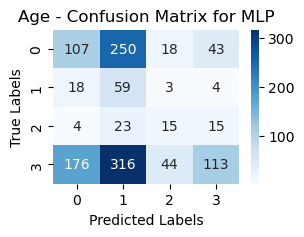

Type 1 and Type 2 error extraction is only applicable for binary classification.
Class 0: Type 1 Error = 198, Type 2 Error = 311
Class 1: Type 1 Error = 589, Type 2 Error = 25
Class 2: Type 1 Error = 65, Type 2 Error = 42
Class 3: Type 1 Error = 62, Type 2 Error = 536


In [2312]:
#Evaluate the classifier 
print("**************** MLP CLASSIFIER MODEL RESULTS -- for Age **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_age,y_pred_mlp_age),5))

print("F1 score for testing set:", round(f1_score(y_test_age, y_pred_mlp_age, average='weighted'), 5))
print("Recall score for testing set:", round(recall_score(y_test_age, y_pred_mlp_age, average='weighted'), 5))
print("Precision score for testing set:", round(precision_score(y_test_age, y_pred_mlp_age, average='weighted'), 5))

cm_lr = confusion_matrix(y_test_age, y_pred_mlp_age)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Age - Confusion Matrix for MLP')

ax.xaxis.set_ticklabels(['0', '1', '2', '3'])  # Replace with your actual class labels
ax.yaxis.set_ticklabels(['0', '1', '2', '3'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel() if cm_lr.size == 4 else (None, None, None, None)  # Works for binary case only
if tn is not None and fp is not None:
    type1_error = fp  # False Positives
    type2_error = fn  # False Negatives

    print(f"Type 1 Error (False Positives): {type1_error}")
    print(f"Type 2 Error (False Negatives): {type2_error}")
else:
    print("Type 1 and Type 2 error extraction is only applicable for binary classification.")


for i, class_label in enumerate(['0', '1', '2', '3']):  # Replace with actual class names
    type1_error = cm_lr[:, i].sum() - cm_lr[i, i]  # False Positives for this class
    type2_error = cm_lr[i, :].sum() - cm_lr[i, i]  # False Negatives for this class
    print(f"Class {class_label}: Type 1 Error = {type1_error}, Type 2 Error = {type2_error}")

### Model 6 - K Nearest Classifier

In [2314]:
# Object creation, fitting the data & getting predictions 
k = 5  # Number of neighbors
knn_gender = KNeighborsClassifier(n_neighbors=k)
#Train the classifier
knn_gender.fit(X_train_gender,y_train_gender) 

#Predict on the test set
y_pred_knn_gender = knn_gender.predict(X_test_gender) 

In [2315]:
# Evaluate model performance
print("Gender Prediction Accuracy:", accuracy_score(y_test_gender, y_pred_knn_gender))
print("Gender Classification Report:\n", classification_report(y_test_gender, y_pred_knn_gender))

Gender Prediction Accuracy: 0.5389072847682119
Gender Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.44      0.36       358
           1       0.71      0.58      0.64       850

    accuracy                           0.54      1208
   macro avg       0.51      0.51      0.50      1208
weighted avg       0.59      0.54      0.56      1208



**************** LOGISTIC REGRESSION CLASSIFIER MODEL RESULTS -- for Gender **************** 
Accuracy score for testing set:  0.53891
F1 score for testing set:  0.63995
Recall score for testing set:  0.58235
Precision score for testing set:  0.71019


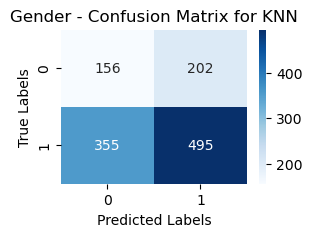

Type 1 Error (False Positives): 202
False Positive Rate (FPR): 0.5642
Type 2 Error (False Negatives): 355


In [2316]:
#Evaluate the classifier 
print("**************** LOGISTIC REGRESSION CLASSIFIER MODEL RESULTS -- for Gender **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_gender,y_pred_knn_gender),5))
print('F1 score for testing set: ',round(f1_score(y_test_gender,y_pred_knn_gender),5))
print('Recall score for testing set: ',round(recall_score(y_test_gender,y_pred_knn_gender),5))
print('Precision score for testing set: ',round(precision_score(y_test_gender,y_pred_knn_gender),5))
cm_lr = confusion_matrix(y_test_gender, y_pred_knn_gender)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Gender - Confusion Matrix for KNN')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel()  # True Negative, False Positive, False Negative, True Positive
type1_error = fp  # False Positives
type2_error = fn  # False Negatives
fpr = fp / (fp + tn)

print(f"Type 1 Error (False Positives): {type1_error}")
print(f"False Positive Rate (FPR): {fpr:.4f}") #The model incorrectly predicts females as males ~37.7% of the time.
print(f"Type 2 Error (False Negatives): {type2_error}")

In [2317]:
# Object creation, fitting the data & getting predictions 
k = 5  # Number of neighbors
knn_age = KNeighborsClassifier(n_neighbors=k)
#Train the classifier
knn_age.fit(X_train_age,y_train_age) 

#Predict on the test set
y_pred_knn_age = knn_age.predict(X_test_age) 

In [2318]:
# Evaluate model performance
print("Age Prediction Accuracy:", accuracy_score(y_test_age, y_pred_knn_age))
print("Age Classification Report:\n", classification_report(y_test_age, y_pred_knn_age))

Age Prediction Accuracy: 0.31125827814569534
Age Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.33      0.34       418
           1       0.10      0.31      0.15        84
           2       0.06      0.21      0.10        57
           3       0.55      0.31      0.40       649

    accuracy                           0.31      1208
   macro avg       0.27      0.29      0.25      1208
weighted avg       0.43      0.31      0.35      1208



****************  K nearest CLASSIFIER MODEL RESULTS -- for Age **************** 
Accuracy score for testing set:  0.31126
F1 score for testing set: 0.3455
Recall score for testing set: 0.31126
Precision score for testing set: 0.42712


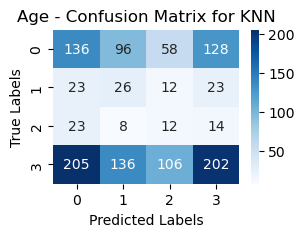

Type 1 and Type 2 error extraction is only applicable for binary classification.
Class 0: Type 1 Error = 251, Type 2 Error = 282
Class 1: Type 1 Error = 240, Type 2 Error = 58
Class 2: Type 1 Error = 176, Type 2 Error = 45
Class 3: Type 1 Error = 165, Type 2 Error = 447


In [2346]:
#Evaluate the classifier 
print("****************  K nearest CLASSIFIER MODEL RESULTS -- for Age **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_age,y_pred_knn_age),5))

print("F1 score for testing set:", round(f1_score(y_test_age, y_pred_knn_age, average='weighted'), 5))
print("Recall score for testing set:", round(recall_score(y_test_age, y_pred_knn_age, average='weighted'), 5))
print("Precision score for testing set:", round(precision_score(y_test_age, y_pred_knn_age, average='weighted'), 5))

cm_lr = confusion_matrix(y_test_age, y_pred_knn_age)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Age - Confusion Matrix for KNN')

ax.xaxis.set_ticklabels(['0', '1', '2', '3'])  # Replace with your actual class labels
ax.yaxis.set_ticklabels(['0', '1', '2', '3'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel() if cm_lr.size == 4 else (None, None, None, None)  # Works for binary case only
if tn is not None and fp is not None:
    type1_error = fp  # False Positives
    type2_error = fn  # False Negatives

    print(f"Type 1 Error (False Positives): {type1_error}")
    print(f"Type 2 Error (False Negatives): {type2_error}")
else:
    print("Type 1 and Type 2 error extraction is only applicable for binary classification.")

for i, class_label in enumerate(['0', '1', '2', '3']):  # Replace with actual class names
    type1_error = cm_lr[:, i].sum() - cm_lr[i, i]  # False Positives for this class
    type2_error = cm_lr[i, :].sum() - cm_lr[i, i]  # False Negatives for this class
    print(f"Class {class_label}: Type 1 Error = {type1_error}, Type 2 Error = {type2_error}")

In [2320]:
# from sklearn.model_selection import cross_val_score

# # Test different values of k
# k_values = range(1, 21)
# accuracies = []

# for k in k_values:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
#     accuracies.append(cv_scores.mean())

# # Plot accuracy vs. k
# plt.plot(k_values, accuracies)
# plt.xlabel('Number of Neighbors (k)')
# plt.ylabel('Cross-Validated Accuracy')
# plt.title('Optimal k for k-NN')
# plt.show()

# # Best k
# best_k = k_values[np.argmax(accuracies)]
# print(f"Best k: {best_k}")


### Model 7 - Decision Tree

In [2322]:
# Initialize the Decision Tree Classifier
dt_gender = DecisionTreeClassifier(random_state=42, max_depth=5)
# Train the model
dt_gender.fit(X_train_gender, y_train_gender)

# Make predictions on the test set
y_pred_dt_gender = dt_gender.predict(X_test_gender)

In [2323]:
# Evaluate model performance
print("Gender Prediction Accuracy:", accuracy_score(y_test_gender, y_pred_dt_gender))
print("Gender Classification Report:\n", classification_report(y_test_gender, y_pred_dt_gender))

Gender Prediction Accuracy: 0.6995033112582781
Gender Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.69      0.58       358
           1       0.84      0.70      0.77       850

    accuracy                           0.70      1208
   macro avg       0.67      0.70      0.67      1208
weighted avg       0.74      0.70      0.71      1208



**************** Decision Tree CLASSIFIER MODEL RESULTS -- for Gender **************** 
Accuracy score for testing set:  0.6995
F1 score for testing set:  0.76746
Recall score for testing set:  0.70471
Precision score for testing set:  0.84248


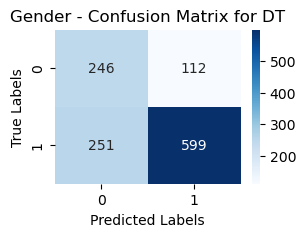

Type 1 Error (False Positives): 112
False Positive Rate (FPR): 0.3128
Type 2 Error (False Negatives): 251


In [2394]:
#Evaluate the classifier 
print("**************** Decision Tree CLASSIFIER MODEL RESULTS -- for Gender **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_gender,y_pred_dt_gender),5))
print('F1 score for testing set: ',round(f1_score(y_test_gender,y_pred_dt_gender),5))
print('Recall score for testing set: ',round(recall_score(y_test_gender,y_pred_dt_gender),5))
print('Precision score for testing set: ',round(precision_score(y_test_gender,y_pred_dt_gender),5))
cm_lr = confusion_matrix(y_test_gender, y_pred_dt_gender)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Gender - Confusion Matrix for DT')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel()  # True Negative, False Positive, False Negative, True Positive
type1_error = fp  # False Positives
type2_error = fn  # False Negatives
fpr = fp / (fp + tn)

print(f"Type 1 Error (False Positives): {type1_error}")
print(f"False Positive Rate (FPR): {fpr:.4f}") #The model incorrectly predicts females as males ~37.7% of the time.
print(f"Type 2 Error (False Negatives): {type2_error}")

In [2325]:
# Initialize the Decision Tree Classifier
dt_age = DecisionTreeClassifier(random_state=42, max_depth=5)

# Train the model
dt_age.fit(X_train_age, y_train_age)

# Make predictions on the test set
y_pred_dt_age = dt_age.predict(X_test_age)

In [2326]:
# Evaluate model performance
print("Age Prediction Accuracy:", accuracy_score(y_test_age, y_pred_dt_age))
print("Age Classification Report:\n", classification_report(y_test_age, y_pred_dt_age))


Age Prediction Accuracy: 0.3435430463576159
Age Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.24      0.30       418
           1       0.10      0.45      0.17        84
           2       0.13      0.47      0.21        57
           3       0.63      0.39      0.48       649

    accuracy                           0.34      1208
   macro avg       0.32      0.39      0.29      1208
weighted avg       0.49      0.34      0.38      1208



**************** Decision Tree CLASSIFIER MODEL RESULTS -- for Age **************** 
Accuracy score for testing set:  0.34354
F1 score for testing set: 0.38298
Recall score for testing set: 0.34354
Precision score for testing set: 0.49417


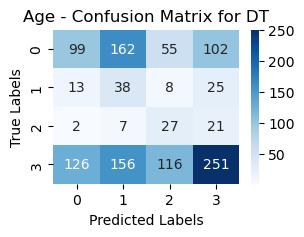

Type 1 and Type 2 error extraction is only applicable for binary classification.
Class 0: Type 1 Error = 141, Type 2 Error = 319
Class 1: Type 1 Error = 325, Type 2 Error = 46
Class 2: Type 1 Error = 179, Type 2 Error = 30
Class 3: Type 1 Error = 148, Type 2 Error = 398


In [2396]:
#Evaluate the classifier 
print("**************** Decision Tree CLASSIFIER MODEL RESULTS -- for Age **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_age,y_pred_dt_age),5))

print("F1 score for testing set:", round(f1_score(y_test_age, y_pred_dt_age, average='weighted'), 5))
print("Recall score for testing set:", round(recall_score(y_test_age, y_pred_dt_age, average='weighted'), 5))
print("Precision score for testing set:", round(precision_score(y_test_age, y_pred_dt_age, average='weighted'), 5))

cm_lr = confusion_matrix(y_test_age, y_pred_dt_age)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Age - Confusion Matrix for DT')

ax.xaxis.set_ticklabels(['0', '1', '2', '3'])  # Replace with your actual class labels
ax.yaxis.set_ticklabels(['0', '1', '2', '3'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel() if cm_lr.size == 4 else (None, None, None, None)  # Works for binary case only
if tn is not None and fp is not None:
    type1_error = fp  # False Positives
    type2_error = fn  # False Negatives

    print(f"Type 1 Error (False Positives): {type1_error}")
    print(f"Type 2 Error (False Negatives): {type2_error}")
else:
    print("Type 1 and Type 2 error extraction is only applicable for binary classification.")



for i, class_label in enumerate(['0', '1', '2', '3']):  # Replace with actual class names
    type1_error = cm_lr[:, i].sum() - cm_lr[i, i]  # False Positives for this class
    type2_error = cm_lr[i, :].sum() - cm_lr[i, i]  # False Negatives for this class
    print(f"Class {class_label}: Type 1 Error = {type1_error}, Type 2 Error = {type2_error}")

#### Model 8 - Naive Bayes

In [2329]:
# Object creation, fitting the data & getting predictions 
gnb_gender= GaussianNB()

#Train the classifier
gnb_gender.fit(X_train_gender,y_train_gender) 

#Predict on the test set
y_pred_gnb_gender = gnb_gender.predict(X_test_gender) 

In [2330]:
# Evaluate model performance
print("Gender Prediction Accuracy:", accuracy_score(y_test_gender, y_pred_gnb_gender))
print("Gender Classification Report:\n", classification_report(y_test_gender, y_pred_gnb_gender))

Gender Prediction Accuracy: 0.6084437086092715
Gender Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.78      0.54       358
           1       0.85      0.54      0.66       850

    accuracy                           0.61      1208
   macro avg       0.63      0.66      0.60      1208
weighted avg       0.72      0.61      0.62      1208



**************** Naive Bayes CLASSIFIER MODEL RESULTS -- for Gender **************** 
Accuracy score for testing set:  0.60844
F1 score for testing set:  0.65898
Recall score for testing set:  0.53765
Precision score for testing set:  0.85102


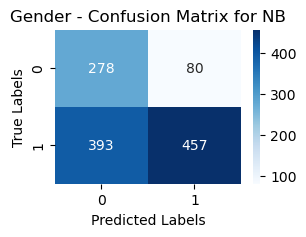

Type 1 Error (False Positives): 80
False Positive Rate (FPR): 0.2235
Type 2 Error (False Negatives): 393


In [2398]:

#Evaluate the classifier 
print("**************** Naive Bayes CLASSIFIER MODEL RESULTS -- for Gender **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_gender,y_pred_gnb_gender),5))
print('F1 score for testing set: ',round(f1_score(y_test_gender,y_pred_gnb_gender),5))
print('Recall score for testing set: ',round(recall_score(y_test_gender,y_pred_gnb_gender),5))
print('Precision score for testing set: ',round(precision_score(y_test_gender,y_pred_gnb_gender),5))
cm_lr = confusion_matrix(y_test_gender, y_pred_gnb_gender)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Gender - Confusion Matrix for NB')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel()  # True Negative, False Positive, False Negative, True Positive
type1_error = fp  # False Positives
type2_error = fn  # False Negatives
fpr = fp / (fp + tn)

print(f"Type 1 Error (False Positives): {type1_error}")
print(f"False Positive Rate (FPR): {fpr:.4f}") #The model incorrectly predicts females as males ~37.7% of the time.
print(f"Type 2 Error (False Negatives): {type2_error}")

In [2332]:
# Object creation, fitting the data & getting predictions 
gnb_age= GaussianNB()

#Train the classifier
gnb_age.fit(X_train_age,y_train_age) 

#Predict on the test set
y_pred_gnb_age = gnb_age.predict(X_test_age) 

In [2333]:
# Evaluate model performance
print("Age Prediction Accuracy:", accuracy_score(y_test_age, y_pred_gnb_age))
print("Age Classification Report:\n", classification_report(y_test_age, y_pred_gnb_age))

Age Prediction Accuracy: 0.3195364238410596
Age Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.09      0.15       418
           1       0.10      0.57      0.17        84
           2       0.12      0.44      0.19        57
           3       0.65      0.42      0.51       649

    accuracy                           0.32      1208
   macro avg       0.32      0.38      0.26      1208
weighted avg       0.50      0.32      0.35      1208



**************** Naive Bayes CLASSIFIER MODEL RESULTS -- for Age **************** 
Accuracy score for testing set:  0.31954
F1 score for testing set: 0.34805
Recall score for testing set: 0.31954
Precision score for testing set: 0.50195


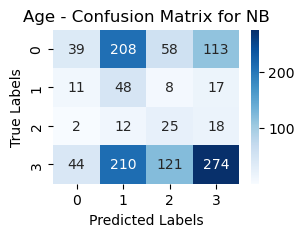

Type 1 and Type 2 error extraction is only applicable for binary classification.
Class 0: Type 1 Error = 57, Type 2 Error = 379
Class 1: Type 1 Error = 430, Type 2 Error = 36
Class 2: Type 1 Error = 187, Type 2 Error = 32
Class 3: Type 1 Error = 148, Type 2 Error = 375


In [2400]:
#Evaluate the classifier 
print("**************** Naive Bayes CLASSIFIER MODEL RESULTS -- for Age **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_age,y_pred_gnb_age),5))

print("F1 score for testing set:", round(f1_score(y_test_age, y_pred_gnb_age, average='weighted'), 5))
print("Recall score for testing set:", round(recall_score(y_test_age, y_pred_gnb_age, average='weighted'), 5))
print("Precision score for testing set:", round(precision_score(y_test_age, y_pred_gnb_age, average='weighted'), 5))

cm_lr = confusion_matrix(y_test_age, y_pred_gnb_age)
# print("Confusion Matrix:\n", cm_lr)
f, ax= plt.subplots(1,1,figsize=(3,2))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Age - Confusion Matrix for NB')

ax.xaxis.set_ticklabels(['0', '1', '2', '3'])  # Replace with your actual class labels
ax.yaxis.set_ticklabels(['0', '1', '2', '3'])
plt.show();

# Extract Type 1 and Type 2 Errors
tn, fp, fn, tp = cm_lr.ravel() if cm_lr.size == 4 else (None, None, None, None)  # Works for binary case only
if tn is not None and fp is not None:
    type1_error = fp  # False Positives
    type2_error = fn  # False Negatives

    print(f"Type 1 Error (False Positives): {type1_error}")
    print(f"Type 2 Error (False Negatives): {type2_error}")
else:
    print("Type 1 and Type 2 error extraction is only applicable for binary classification.")



for i, class_label in enumerate(['0', '1', '2', '3']):  # Replace with actual class names
    type1_error = cm_lr[:, i].sum() - cm_lr[i, i]  # False Positives for this class
    type2_error = cm_lr[i, :].sum() - cm_lr[i, i]  # False Negatives for this class
    print(f"Class {class_label}: Type 1 Error = {type1_error}, Type 2 Error = {type2_error}")

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Iteration 1, loss = 17.88574882
Iteration 2, loss = 15.47845425
Iteration 3, loss = 9.95595384
Iteration 4, loss = 4.30603057
Iteration 5, loss = 2.43890885
Iteration 6, loss = 1.98076206
Iteration 7, loss = 1.69435791
Iteration 8, loss = 1.42846910
Iteration 9, loss = 1.25273815
Iteration 10, loss = 1.09194292
Iteration 11, loss = 1.02486025
Iteration 12, loss = 0.90774775
Iteration 13, loss = 0.85541000
Iteration 14, loss = 0.78153362
Iteration 15, loss = 0.72175077
Iteration 16, loss = 0.69363219
Iteration 17, loss = 0.71301285
Iteration 18, loss = 0.68105989
Iteration 19, loss = 0.67541361
Iteration 20, loss = 0.70711989
Iteration 21, loss = 0.73199995
Iteration 22, loss = 0.69267022
Iteration 23, loss = 0.68111135
Iteration 24, loss = 0.67806776
Iteration 25, loss = 0.63824584
Iteration 26, loss = 0.64839541
Iteration 27, loss = 0.63181563
Iteration 28, loss = 0.65449982
Iteration 29, loss = 0.61238769
Iteration 30, loss = 0.61685766
Iteration 31, loss = 0.62752848
Iteration 32, l

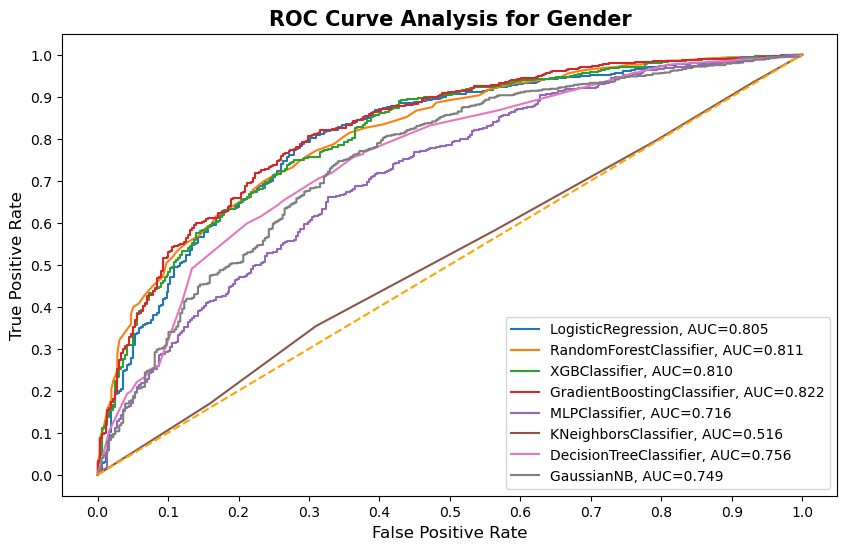

In [2354]:
classifiers = [    
    LogisticRegression(),
    RandomForestClassifier(random_state=42),
    xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_estimators=100,learning_rate=0.1,max_depth=6,random_state=42),
    GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=3,random_state=42),
    MLPClassifier(hidden_layer_sizes=(20,),activation='relu',solver='adam',random_state=42,alpha= 0.05,verbose=True),
    KNeighborsClassifier(5),
    DecisionTreeClassifier(random_state=42, max_depth=5),
    GaussianNB()
]

# List to collect results
results = []

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train_gender, y_train_gender)
    yproba = model.predict_proba(X_test_gender)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test_gender, yproba)
    auc = roc_auc_score(y_test_gender, yproba)
    
    results.append({
        'classifiers': cls.__class__.__name__,
        'fpr': fpr, 
        'tpr': tpr, 
        'auc': auc
    })

# Convert the list of results to a DataFrame
result_table = pd.DataFrame(results)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(10,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=12)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=12)

plt.title('ROC Curve Analysis for Gender', fontweight='bold', fontsize=15)
plt.legend(prop={'size':10}, loc='lower right')

plt.savefig('ROC Curve.png', bbox_inches='tight')
plt.show()

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


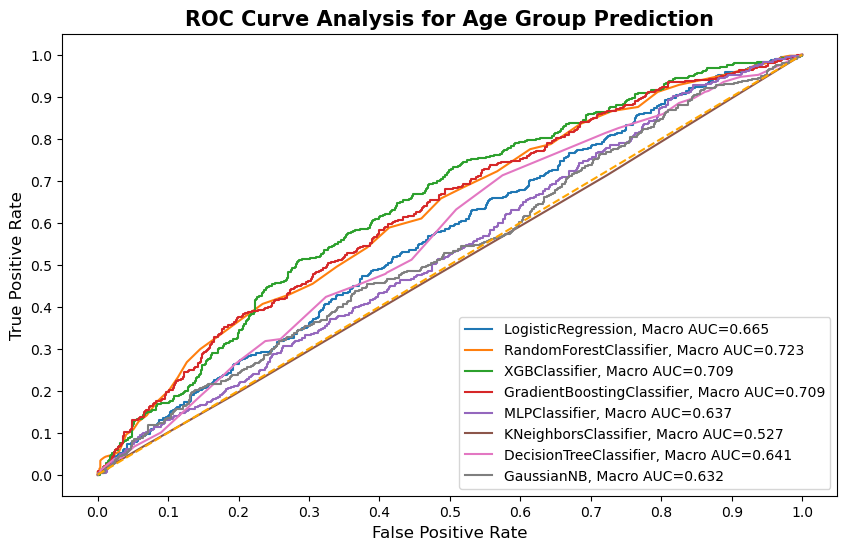

In [2365]:
# Define classifiers
classifiers = [
    LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000),
    RandomForestClassifier(random_state=42),
    xgb.XGBClassifier(objective='multi:softmax', 
                      num_class=len(np.unique(y_train_age)) if len(np.unique(y_train_age)) > 2 else None,
                      eval_metric='mlogloss', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    MLPClassifier(hidden_layer_sizes=(20,), activation='relu', solver='adam', random_state=42, alpha=0.05, verbose=False),
    KNeighborsClassifier(5),
    DecisionTreeClassifier(random_state=42, max_depth=5),
    GaussianNB()
]

# List to collect results
results = []

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train_age, y_train_age)
    
    # Predict probabilities for test data
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_age)
    else:
        # If the model does not support `predict_proba`, use `decision_function` and convert to probabilities
        y_proba = model.decision_function(X_test_age)
    
    # Compute ROC-AUC for each class and macro-average
    aucs = []
    fprs = []
    tprs = []
    for i in range(len(np.unique(y_train_age))):
        fpr, tpr, _ = roc_curve(y_test_age == i, y_proba[:, i])
        auc = roc_auc_score(y_test_age == i, y_proba[:, i])
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc)
    
    # Calculate macro-average AUC
    macro_auc = np.mean(aucs)
    results.append({
        'classifiers': cls.__class__.__name__,
        'fprs': fprs,
        'tprs': tprs,
        'auc': macro_auc
    })

# Convert the list of results to a DataFrame
result_table = pd.DataFrame(results)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
for i, row in result_table.iterrows():
    plt.plot(
        row['fprs'][0], row['tprs'][0], 
        label="{}, Macro AUC={:.3f}".format(row['classifiers'], row['auc'])
    )

plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=12)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=12)
plt.title('ROC Curve Analysis for Age Group Prediction', fontweight='bold', fontsize=15)
plt.legend(prop={'size':10}, loc='lower right')

plt.savefig('ROC Curve_age.png', bbox_inches='tight')
plt.show()

### Evaluation Metrics

In [2363]:
models = [lr_gender,rf_gender,xgb_gender,gb_gender,mlp_gender,knn_gender,dt_gender,gnb_gender]

scoring = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1': 'f1'
}

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each model and perform cross-validation
for model in models:
    model_name = model.__class__.__name__
    print(f"\n{model_name} Cross-Validation Results:")

    pipeline = Pipeline([
            ('scaler', RobustScaler()),  # Apply scaling
            ('classifier', model)         # Apply the model
        ])
    
    # Perform cross-validation
    cv_results = cross_validate(pipeline, features, y_gender, cv=cv, scoring=scoring,  return_train_score=False)#return_estimator=True,
    

    # Print cross-validation results
    for metric in scoring.keys():
        print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f}")

    # for metric in scoring.keys():
    #     print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f} (+/- {cv_results[f'test_{metric}'].std() * 2:.4f})")


#(+/- {cv_results[f'test_{metric}'].std() * 2:.4f})
# # Perform cross-validation
# cv_results = cross_validate(models, X, y, cv=cv, scoring=scoring, return_estimator=True, return_train_score=False)

# # Print cross-validation results
# print("\nRandom Forest Cross-Validation Results:")
# for metric in scoring.keys():
#     print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f} (+/- {cv_results[f'test_{metric}'].std() * 2:.4f})")


LogisticRegression Cross-Validation Results:
AUC: 0.7960
Accuracy: 0.7757
Precision: 0.7845
Recall: 0.9476
F1: 0.8583

RandomForestClassifier Cross-Validation Results:
AUC: 0.7933
Accuracy: 0.7722
Precision: 0.7920
Recall: 0.9254
F1: 0.8535

XGBClassifier Cross-Validation Results:
AUC: 0.7976
Accuracy: 0.7798
Precision: 0.8084
Recall: 0.9083
F1: 0.8554

GradientBoostingClassifier Cross-Validation Results:
AUC: 0.8049
Accuracy: 0.7801
Precision: 0.8025
Recall: 0.9199
F1: 0.8571

MLPClassifier Cross-Validation Results:
Iteration 1, loss = 0.58329286
Iteration 2, loss = 0.52972377
Iteration 3, loss = 0.51148032
Iteration 4, loss = 0.49604891
Iteration 5, loss = 0.48932339
Iteration 6, loss = 0.56120823
Iteration 7, loss = 0.49343306
Iteration 8, loss = 0.48311269
Iteration 9, loss = 0.46610520
Iteration 10, loss = 0.47176338
Iteration 11, loss = 0.45771072
Iteration 12, loss = 0.45193105
Iteration 13, loss = 0.45242464
Iteration 14, loss = 0.43956267
Iteration 15, loss = 0.43884755
Itera

In [2383]:
model_age = [lr_age,rf_age,xgb_age,gb_age,mlp_age,knn_age,dt_age,gnb_age]


scoring_age = {
    'AUC': make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True),
    'Accuracy': 'accuracy',
    'Precision': make_scorer(precision_score, average='weighted'),
    'Recall': make_scorer(recall_score, average='weighted'),
    'F1': make_scorer(f1_score, average='weighted')
}

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each model and perform cross-validation
for model in model_age:
    model_name = model.__class__.__name__
    print(f"\n{model_name} Cross-Validation Results:")

    pipeline = Pipeline([
            ('scaler', RobustScaler()),  # Apply scaling
            ('classifier', model)         # Apply the model
        ])
    
    # Perform cross-validation
    cv_results = cross_validate(pipeline, features, y_age, cv=cv, scoring=scoring_age,  return_train_score=False)#return_estimator=True,
    

    # Print cross-validation results
    for metric in scoring.keys():
        print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f}")

    # for metric in scoring.keys():
    #     print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f} (+/- {cv_results[f'test_{metric}'].std() * 2:.4f})")


#(+/- {cv_results[f'test_{metric}'].std() * 2:.4f})
# # Perform cross-validation
# cv_results = cross_validate(models, X, y, cv=cv, scoring=scoring, return_estimator=True, return_train_score=False)

# # Print cross-validation results
# print("\nRandom Forest Cross-Validation Results:")
# for metric in scoring.keys():
#     print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f} (+/- {cv_results[f'test_{metric}'].std() * 2:.4f})")

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(



LogisticRegression Cross-Validation Results:
AUC: 0.7326
Accuracy: 0.5970
Precision: 0.5699
Recall: 0.5970
F1: 0.5568

RandomForestClassifier Cross-Validation Results:


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC: 0.7349
Accuracy: 0.6091
Precision: 0.5705
Recall: 0.6091
F1: 0.5699

XGBClassifier Cross-Validation Results:
AUC: 0.7462
Accuracy: 0.6189
Precision: 0.5858
Recall: 0.6189
F1: 0.5882

GradientBoostingClassifier Cross-Validation Results:
AUC: 0.7514
Accuracy: 0.6154
Precision: 0.5808
Recall: 0.6154
F1: 0.5836

MLPClassifier Cross-Validation Results:
Iteration 1, loss = 1.16433253
Iteration 2, loss = 0.99705679
Iteration 3, loss = 0.93604202
Iteration 4, loss = 0.90852629
Iteration 5, loss = 0.89628851
Iteration 6, loss = 0.88326172
Iteration 7, loss = 0.86683278
Iteration 8, loss = 0.85460600
Iteration 9, loss = 0.85704246
Iteration 10, loss = 0.84578251
Iteration 11, loss = 0.82658868
Iteration 12, loss = 0.81423792
Iteration 13, loss = 0.81429563
Iteration 14, loss = 0.80077456
Iteration 15, loss = 0.79064163
Iteration 16, loss = 0.78587538
Iteration 17, loss = 0.77889252
Iteration 18, loss = 0.76197774
Iteration 19, loss = 0.75912276
Iteration 20, loss = 0.75041115
Iteration 21, 

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\m

AUC: 0.6597
Accuracy: 0.5742
Precision: 0.5176
Recall: 0.5742
F1: 0.5308

GaussianNB Cross-Validation Results:
AUC: 0.6688
Accuracy: 0.4576
Precision: 0.5176
Recall: 0.4576
F1: 0.4282
